Problem Statement

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import scipy.stats as stats

import re
import math
import json

from sklearn.pipeline import Pipeline
from datetime import datetime

import logging

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape


In [4]:
!gdown 1LlEcoqmNWLk_HLt3kROYWOSH3TNve0gY
!gdown 1tP3fvC_mCqoRBUUy6EhHp4nQv8pdTuho

Downloading...
From (original): https://drive.google.com/uc?id=1LlEcoqmNWLk_HLt3kROYWOSH3TNve0gY
From (redirected): https://drive.google.com/uc?id=1LlEcoqmNWLk_HLt3kROYWOSH3TNve0gY&confirm=t&uuid=c8a87429-0598-496e-82e3-2f77f2f6d5be
To: /content/train_1.csv
100% 278M/278M [00:03<00:00, 79.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tP3fvC_mCqoRBUUy6EhHp4nQv8pdTuho
To: /content/Exog_Campaign_eng
100% 1.10k/1.10k [00:00<00:00, 5.48MB/s]


In [5]:
df = pd.read_csv("train_1.csv")
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [6]:
Exog_Campaign_eng = pd.read_csv("Exog_Campaign_eng")
Exog_Campaign_eng.head()

Exog
0     0
1     0
2     0
3     0
4     0

In [7]:
df.shape
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")

The dataset has 145063 rows and 551 columns


In [8]:
Exog_Campaign_eng.shape
print(f"The dataset has {Exog_Campaign_eng.shape[0]} rows and {Exog_Campaign_eng.shape[1]} columns")

The dataset has 550 rows and 1 columns


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
Exog_Campaign_eng.duplicated().sum()

np.int64(548)

In [11]:
df.isna().sum().sort_values(ascending=False)

2015-07-02    20816
2015-07-01    20740
2015-07-07    20664
2015-07-05    20659
2015-07-04    20654
              ...  
2016-12-31     3465
2016-12-20     3268
2016-12-21     3236
2016-12-24     3189
Page              0
Length: 551, dtype: int64

In [12]:
Exog_Campaign_eng.isna().sum().sort_values(ascending=False)

Exog    0
dtype: int64

In [13]:
# Store original column names
old_cols = df.columns.copy()

# Replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')

# Find changed columns
changed_cols = [c for c, old in zip(df.columns, old_cols) if c != old]

print(f"Number of affected columns: {len(changed_cols)}")
print("Changed columns:")
print(changed_cols)

Number of affected columns: 0
Changed columns:
[]


Replace spaces in column names with underscores for consistency

In [14]:
df.nunique().sort_values(ascending=False)

Page          145063
2016-11-13      9376
2016-04-03      9305
2016-01-11      9284
2016-02-29      9202
               ...  
2015-07-03      6707
2015-07-30      6642
2015-08-03      6561
2015-07-31      6524
2015-08-01      6463
Length: 551, dtype: int64

In [15]:
Exog_Campaign_eng.nunique().sort_values(ascending=False)

Exog    2
dtype: int64

In [16]:
df.dtypes

Page           object
2015-07-01    float64
2015-07-02    float64
2015-07-03    float64
2015-07-04    float64
               ...   
2016-12-27    float64
2016-12-28    float64
2016-12-29    float64
2016-12-30    float64
2016-12-31    float64
Length: 551, dtype: object

In [17]:
Exog_Campaign_eng.dtypes

Exog    int64
dtype: object

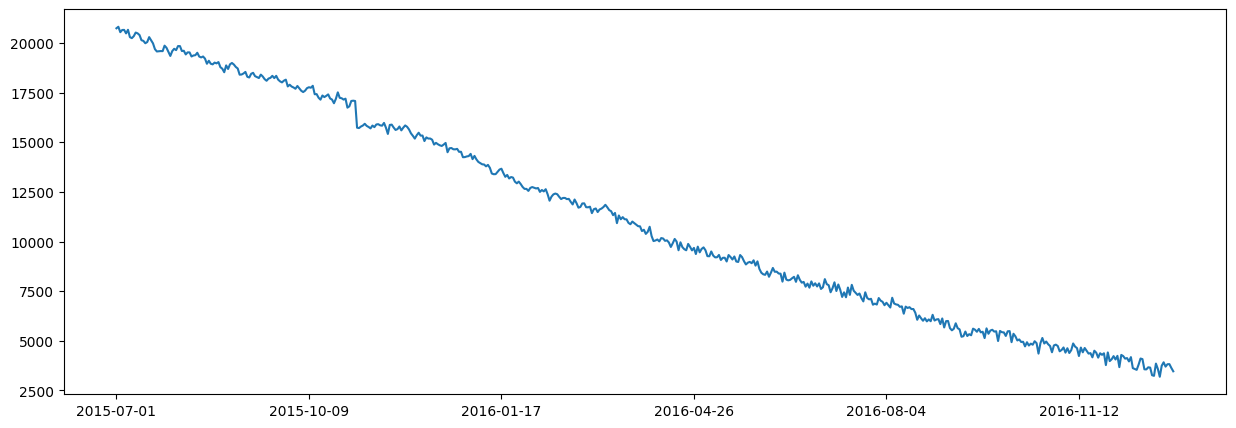

In [18]:
date_columns = df.columns[1:]
df[date_columns].isna().sum().plot(figsize=(15,5))
plt.show()

Insight

It can be observed that the null values keep decreasing with dates, indicating that there were no views for these dates

We can infer that the webpages which were lauched recently will not have view data prior to launch and hence can be filled with 0

In [19]:
df[date_columns] = df.loc[:,date_columns].fillna(0)

In [20]:
df.isna().sum()

Page          0
2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
             ..
2016-12-27    0
2016-12-28    0
2016-12-29    0
2016-12-30    0
2016-12-31    0
Length: 551, dtype: int64

In [21]:
def extract_name(page):
    pattern = r'(.{0,})_(.{2}).wikipedia.org_'
    result = re.findall(pattern, page)
    if len(result) == 1:
        return result[0][0]
    else:
        return 'unknown'
df['name'] = df['Page'].apply(extract_name)

In [22]:
def extract_lang(page):
    pattern = r'(.{0,})_(.{2}).wikipedia.org_'
    result = re.findall(pattern, page)
    if len(result) == 1:
        return result[0][1]
    else:
        return 'un'
df['language'] = df['Page'].apply(extract_lang)
print(df['language'].unique())

['zh' 'fr' 'en' 'un' 'ru' 'de' 'ja' 'es']


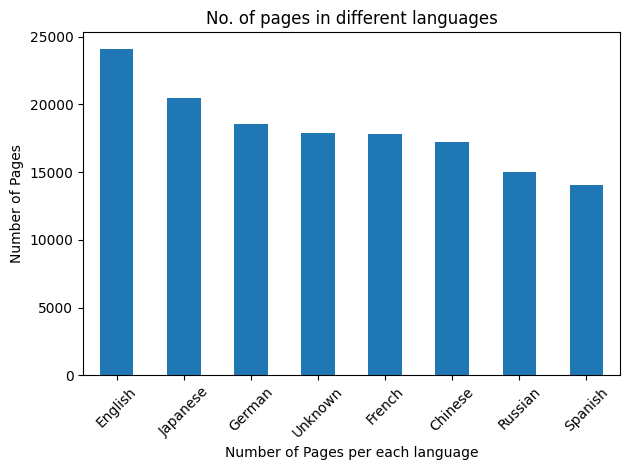

% of pages in different languages


language
English     16.62
Japanese    14.08
German      12.79
Unknown     12.31
French      12.27
Chinese     11.88
Russian     10.36
Spanish      9.70
Name: proportion, dtype: float64

In [23]:
lang_name_mapping={'zh':'Chinese', 'fr':'French', 'en':'English',
                   'un':'Unknown', 'ru':'Russian', 'de':'German',
                   'ja':'Japanese', 'es':'Spanish'}
df['language'] = df['language'].map(lang_name_mapping)
df['language'].value_counts().plot(kind='bar', title='No. of pages in different languages', ylabel='Number of Pages', xlabel='Number of Pages per each language', rot=45)
plt.tight_layout()
plt.show()
print("% of pages in different languages")
round(df['language'].value_counts(normalize=True)*100,2)

Insight

Maximum number of pages, 16.62%, are in English language

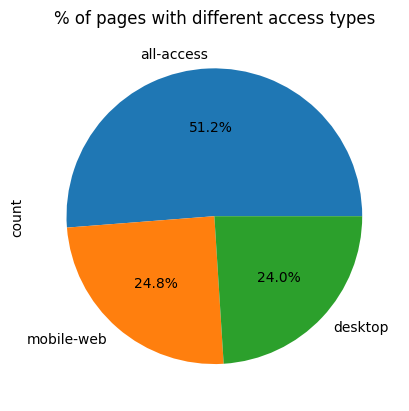

In [24]:
df['access_type'] = df['Page'].str.findall(r'all-access|mobile-web|desktop').apply(lambda x: x[0])
df['access_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='% of pages with different access types')
plt.show()

Insight

Maximum number of pages, 51.2%, have all-access access type

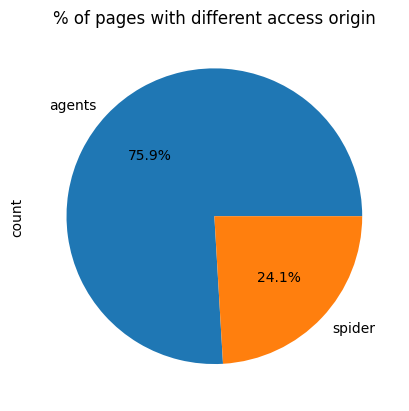

In [25]:
df['access_origin'] = df['Page'].str.findall(r'spider|agents').apply(lambda x: x[0])
df['access_origin'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='% of pages with different access origin')
plt.show()

Insight

Maximum number of pages, 75.9%, have agents access origin

In [26]:
df_agg = df.drop(columns=['Page', 'name', 'access_type', 'access_origin']).groupby('language').mean().T.reset_index()
df_agg['index'] = pd.to_datetime(df_agg['index'])
df_agg = df_agg.set_index('index')
df_agg.head()

language       Chinese      English      French      German    Japanese  \
index                                                                     
2015-07-01  240.582042  3513.862203  475.150994  714.968405  580.647056   
2015-07-02  240.941958  3502.511407  478.202000  705.229741  666.672801   
2015-07-03  239.344071  3325.357889  459.837659  676.877231  602.289805   
2015-07-04  241.653491  3462.054256  491.508932  621.145145  756.509177   
2015-07-05  257.779674  3575.520035  482.557746  722.076185  725.720914   

language       Russian      Spanish    Unknown  
index                                           
2015-07-01  629.999601  1085.972919  83.479922  
2015-07-02  640.902876  1037.814557  87.471857  
2015-07-03  594.026295   954.412680  82.680538  
2015-07-04  558.728132   896.050750  70.572557  
2015-07-05  595.029157   974.508210  78.214562

In [27]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   550 non-null    float64
 1   English   550 non-null    float64
 2   French    550 non-null    float64
 3   German    550 non-null    float64
 4   Japanese  550 non-null    float64
 5   Russian   550 non-null    float64
 6   Spanish   550 non-null    float64
 7   Unknown   550 non-null    float64
dtypes: float64(8)
memory usage: 38.7 KB


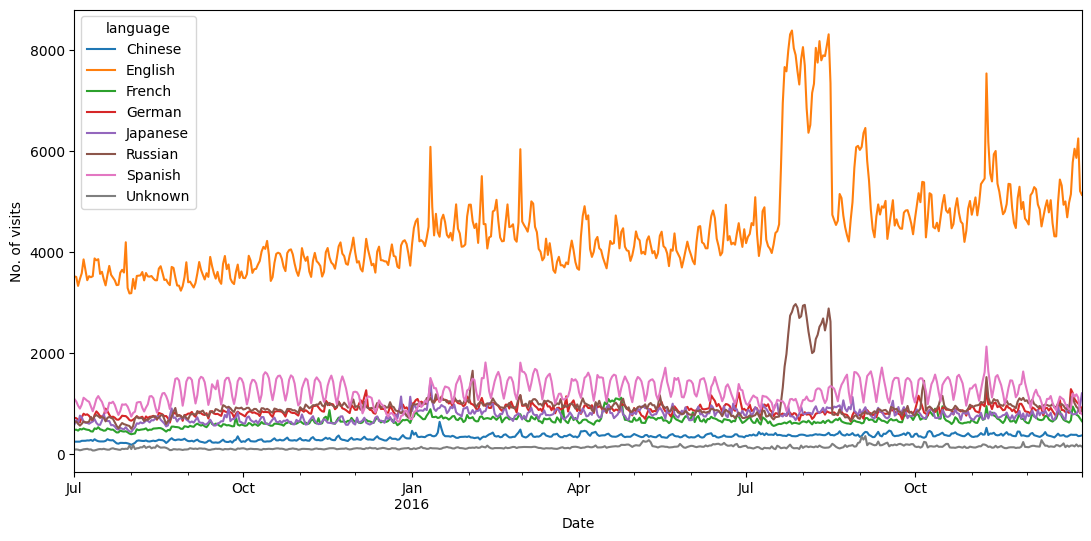

In [28]:
df_agg.plot(figsize=(13,6))
plt.xlabel('Date')
plt.ylabel('No. of visits')
plt.show()

Insight

English pages are the most visited pages follwed by Spanish

English pages have an upward trend in terms of visits

There is an unusual peak from mid of July to end of August 2016

Stationarity test

Using Augmented Dickey-Fuller test to check for stationarity

H0: The series is not stationary

H1: The series is stationary

In [29]:
def Dickey_Fuller_test(time_series):
    p_value = sm.tsa.stattools.adfuller(time_series)[1]
    if(p_value < 0.05):
        print('The time series is stationary')
    else:
        print('The time series is not stationary')

In [30]:
for lang in df_agg.columns:
    print(lang)
    Dickey_Fuller_test(df_agg[lang])
    print()

Chinese
The time series is not stationary

English
The time series is not stationary

French
The time series is not stationary

German
The time series is not stationary

Japanese
The time series is not stationary

Russian
The time series is stationary

Spanish
The time series is stationary

Unknown
The time series is stationary



Insight
Based on the Augmented Dickey-Fuller test, the time series corresponding to
*   Russian and Spanish language page visits are stationary
*   The time series corresponding to Chinese, English, French, German and Japanese language page visits are not stationary

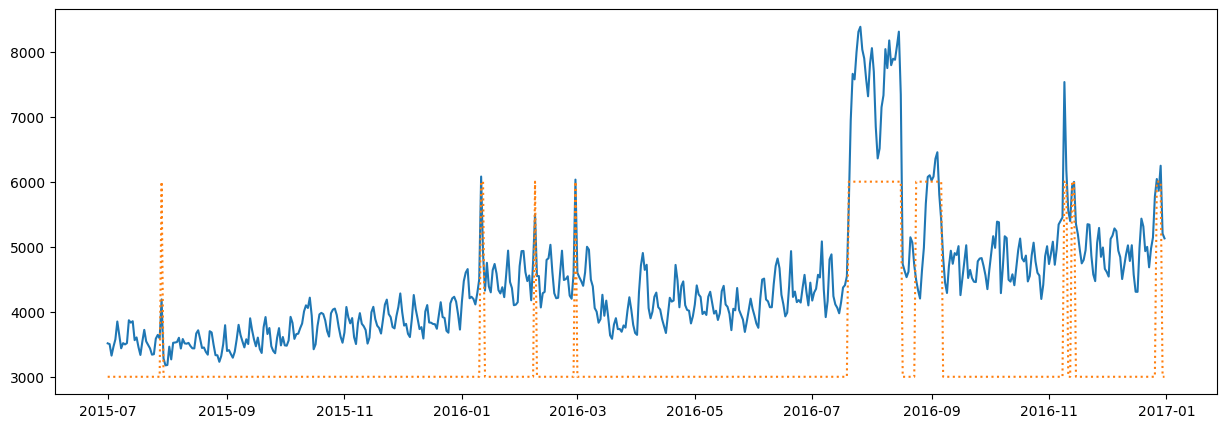

In [31]:
ts_english = df_agg['English']
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ts_english.index, ts_english)
ax.plot(ts_english.index, (Exog_Campaign_eng+1)*3000, ':')
plt.show()

Insight

It is very clear from the above plot that the time series looks like an additive time series with linear up trend and linear sesonality

The unusual spikes in the visits are due to the special events marked by the orange peaks


> **As the trend is linear, differencing with the previous value should de-trend the time series**



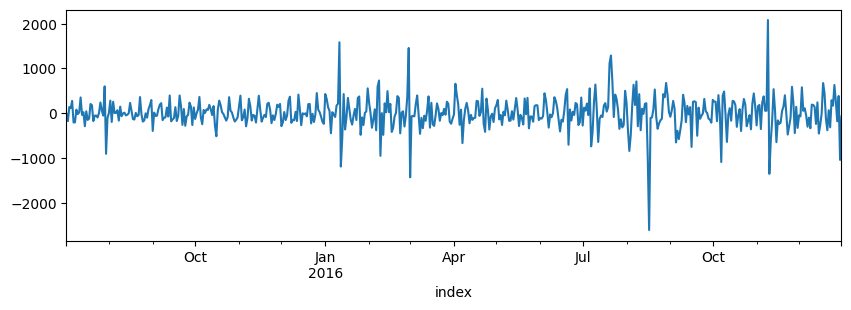

In [32]:
ts_english.diff(1).dropna().plot(figsize=(10,3))
plt.show()

In [33]:
Dickey_Fuller_test(ts_english.diff(1).dropna())

The time series is stationary


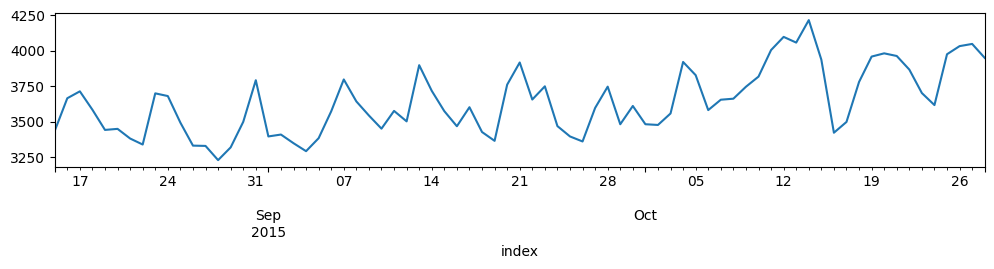

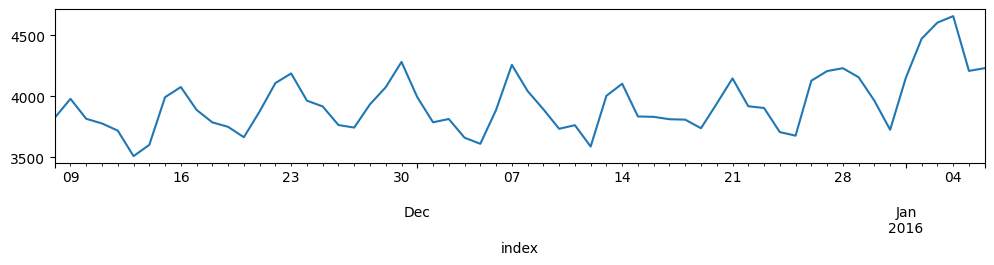

In [34]:
ts_english[45:120].plot(figsize=(12,2))
plt.show()
ts_english[130:190].plot(figsize=(12,2))
plt.show()


Observing the above two plots, we can conclude that there is a seasonality of 7 days. So s=7

The peaks and troughs repeat every 7 days

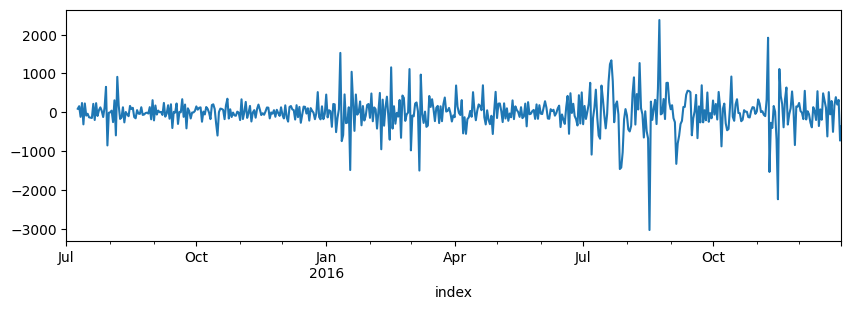

In [35]:
ts_english.diff(1).diff(7).plot(figsize=(10,3))
plt.show()

After removing the trend(and if required, seasonality) manually, the Augmented Dickey-Fuller test says that the time series is stationary

In [36]:
Dickey_Fuller_test(ts_english.diff(1).diff(7).dropna())

The time series is stationary


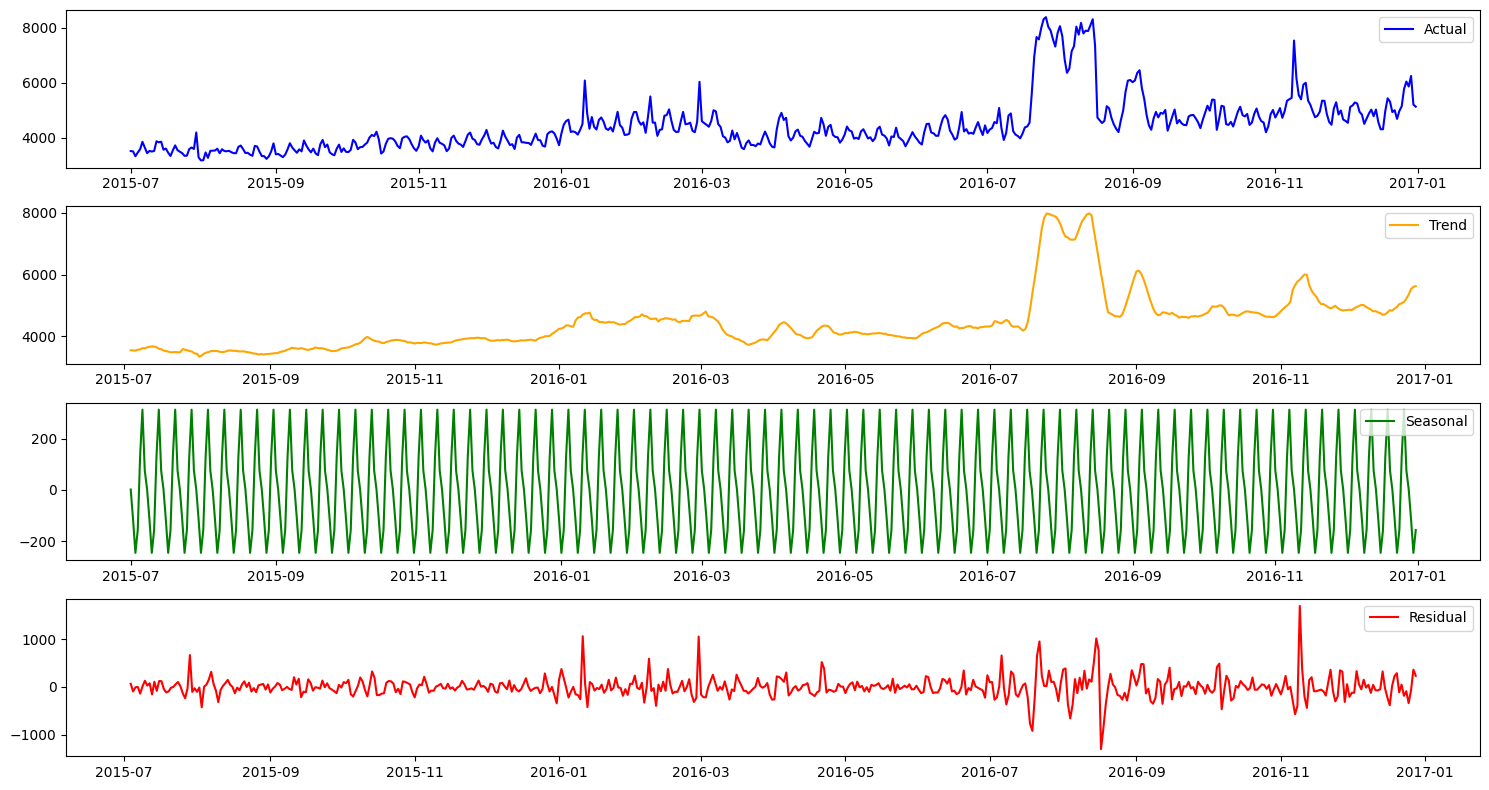

In [37]:
# Decompose the time series
decom = seasonal_decompose(ts_english)

# Extract components
ts_english_trend = decom.trend
ts_english_seas = decom.seasonal
ts_english_res = decom.resid

# Plot all components
plt.figure(figsize=(15, 8))

# Actual series
plt.subplot(4, 1, 1)
plt.plot(ts_english, label='Actual', color='blue')
plt.legend()

# Trend
plt.subplot(4, 1, 2)
plt.plot(ts_english_trend, label='Trend', color='orange')
plt.legend()

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(ts_english_seas, label='Seasonal', color='green')
plt.legend()

# Residual
plt.subplot(4, 1, 4)
plt.plot(ts_english_res, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()

ACF and PACF plots

* The ACF plot shows the correlation of a time series with itself at different
lags, while the PACF plot shows the correlation of a time series with itself at different lags, after removing the effects of the previous lag
* The ACF plot can be used to identify the order of an AR model. The order of an AR model is the number of lags that are included in the model. The ACF plot will show spikes at the lags that are included in the model.
* The PACF plot can be used to identify the order of an MA model. The order of an MA model is the number of lags that are included in the model. The PACF plot will show spikes at the lags that are included in the model

Note: Stationary data needs to be provided to the ACF and PACF plots

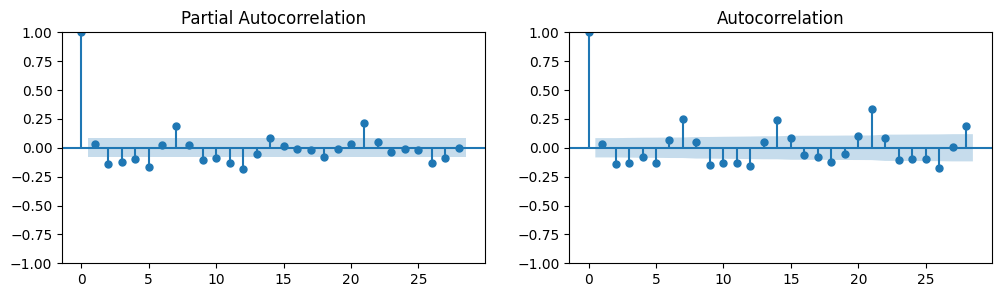

In [38]:
fig, axs = plt.subplots(1,2, figsize=(12, 3))
plot_pacf(ax=axs[0], x=ts_english.diff(1).dropna())
plot_acf(ax=axs[1], x=ts_english.diff(1).dropna())
plt.show()

From the PACF plot, we can see that there are 3 significant lags, at 5, 7 and 21. So P=1,2 or 3

From the ACF plot, we can see that there are 3 significant lags, at 7, 14 and 21. So Q=1,2 or 3

From the PACF plot, the cut-off is right from lag 0 and same for ACF plot. hence, p and q = 0 or 1

In [39]:
correlations = []
for lag in range(1,30):
  present = ts_english[:-lag]
  past = ts_english.shift(-lag)[:-lag]
  corrs = np.corrcoef(present, past)[0,-1]
  print(lag,corrs)
  correlations.append(corrs)

1 0.9363434527458435
2 0.8682966716039896
3 0.8185418037184544
4 0.7846718829500342
5 0.7612561076942573
6 0.7542260641783559
7 0.7386829287516693
8 0.6912638018189877
9 0.6370978014300401
10 0.6015277501876303
11 0.5825450402423571
12 0.5812931934793534
13 0.6007266462817789
14 0.6142525351445116
15 0.5971084554755528
16 0.5693834937428246
17 0.5488401467532626
18 0.5377431132136109
19 0.5430816743411203
20 0.5552694244923043
21 0.5540623423718063
22 0.5092655604869363
23 0.45373695576813583
24 0.4112336297620323
25 0.38162860616251737
26 0.3651996316699481
27 0.3723603627302601
28 0.37818226683160033
29 0.35939242667328175


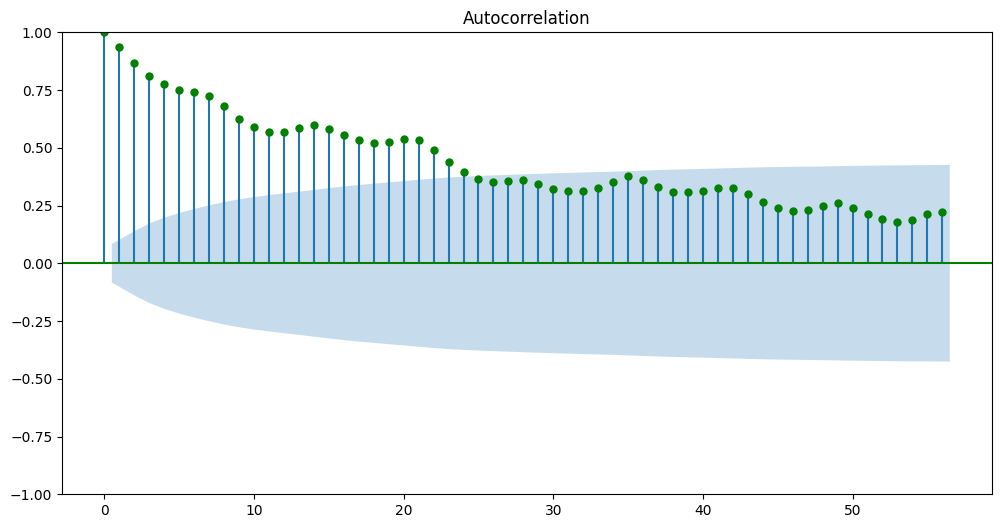

In [40]:
plt.rcParams['figure.figsize'] = (12, 6)
plot_acf(ts_english, lags=56, color='green')
plt.show()

In [41]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted, print_metrics=True):
    MAE = round(mae(actual, predicted), 3)
    RMSE = round(mse(actual, predicted)**0.5, 3)
    MAPE = round(mape(actual, predicted), 3)
    if(print_metrics==True):
        print('MAE :', MAE)
        print('RMSE :', RMSE)
        print('MAPE:', MAPE)
    return MAE, RMSE, MAPE




> **ARIMA MODEL**



## ARIMA

- **Autoregressive Integrated Moving Average (ARIMA)** model, and extensions  
- This model is the basic interface for ARIMA-type models, including those with exogenous regressors and those with seasonal components.  
- The most general form of the model is:  
  **SARIMAX(p, d, q) × (P, D, Q, s)**  
  It also allows all specialized cases, including autoregressive models: **AR(p)**

---

**Moving average models**: `MA(q)`  

**Mixed autoregressive moving average models**: `ARMA(p, q)`  

**Integration models**: `ARIMA(p, d, q)`  

**Seasonal models**: `SARIMA(P, D, Q, s)`  

**Regression with errors** that follow one of the above ARIMA-type models


In [42]:
TS = ts_english.copy(deep=True)

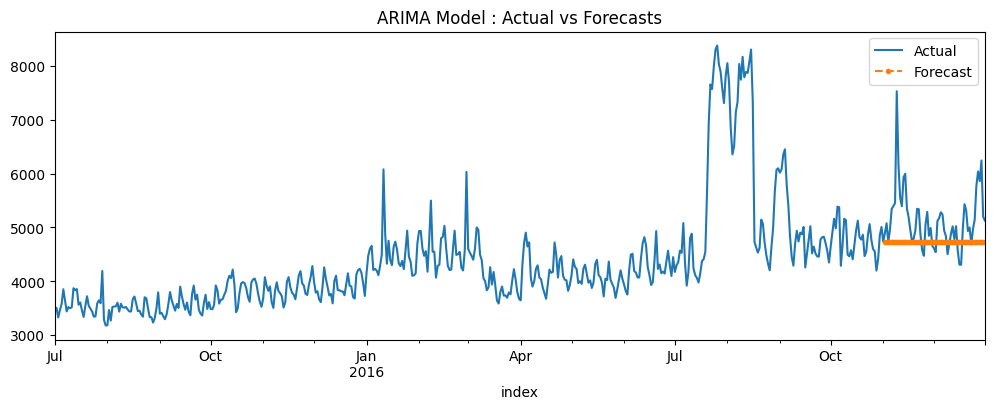

MAE : 477.636
RMSE : 672.778
MAPE: 0.086


(477.636, 672.778, 0.086)

In [43]:
n_forecast = 60

# Fit ARIMA model
model = ARIMA(TS[:-n_forecast], order=(0, 1, 0))
model_fit = model.fit()

# Forecast next n_forecast steps
predicted = model_fit.forecast(steps=n_forecast, alpha=0.05)

# Plot actual vs forecast
plt.figure(figsize=(12, 4))
TS.plot(label='Actual')
predicted.plot(label='Forecast', linestyle='dashed', marker='.')
plt.legend(loc="upper right")
plt.title('ARIMA Model : Actual vs Forecasts')
plt.show()

# Performance metrics
performance(TS.values[-n_forecast:], predicted.values, print_metrics=True)

Insight

The model is not doing a good job, even for different combinations of p and q



> **SARIMAX MODEL**



In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

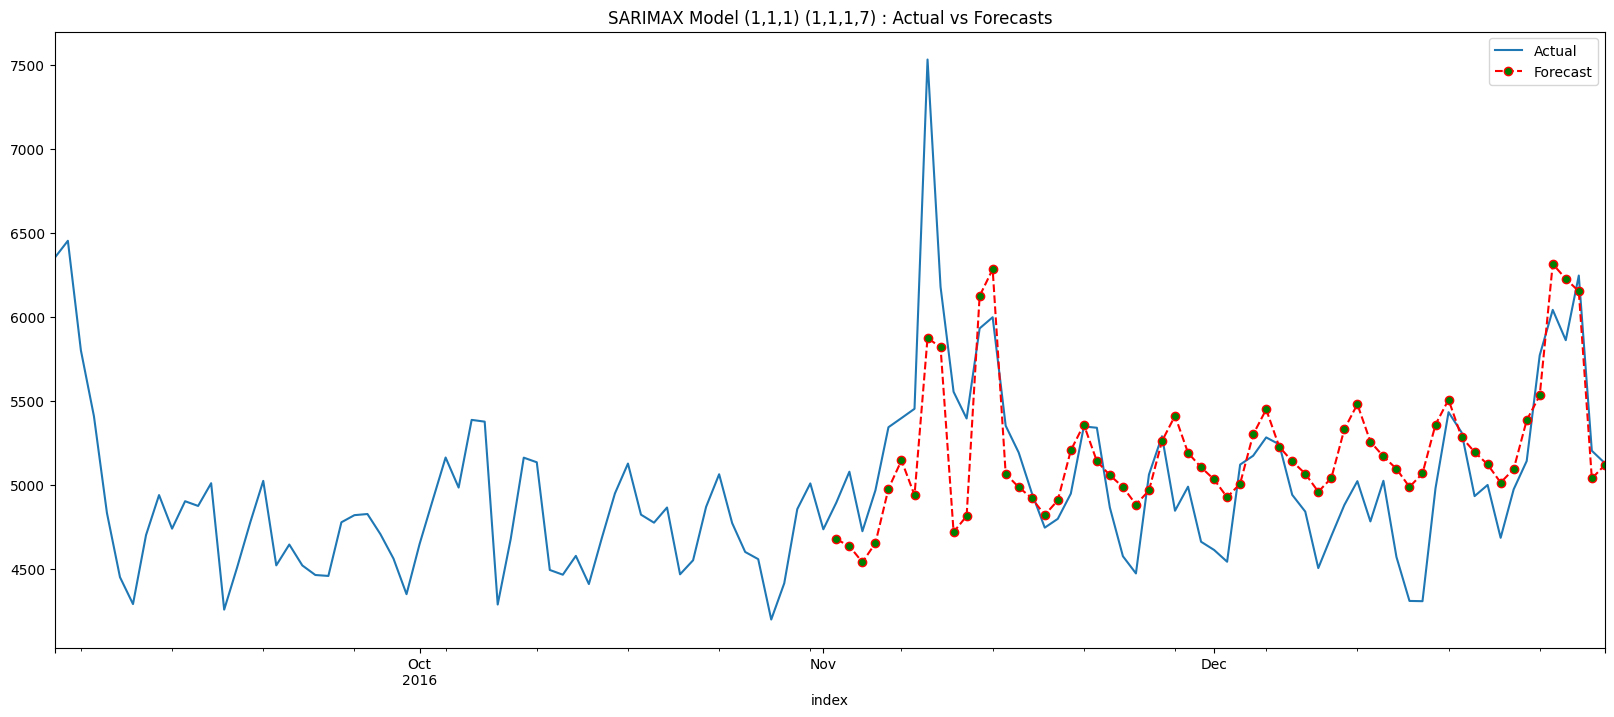

MAE : 306.416
RMSE : 399.015
MAPE: 0.06


(306.416, 399.015, 0.06)

In [45]:
# Parameters
exog = Exog_Campaign_eng['Exog'].to_numpy()
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7
n_forecast = 60

# Fit SARIMAX model
model = SARIMAX(
    TS[:-n_forecast],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=exog[:-n_forecast],
    initialization='approximate_diffuse'
)
model_fit = model.fit()

# Forecast last n values
model_forecast = model_fit.forecast(
    steps=n_forecast,
    dynamic=True,
    exog=pd.DataFrame(exog[-n_forecast:])
)

# Plot actual vs forecast
plt.figure(figsize=(20, 8))
TS[-120:].plot(label='Actual')
model_forecast[-120:].plot(
    label='Forecast',
    color='red',
    linestyle='dashed',
    marker='o',
    markerfacecolor='green'
)
plt.legend(loc="upper right")
plt.title(f"SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts")
plt.show()

# Performance metrics
performance(TS.values[-n_forecast:], model_forecast.values, print_metrics=True)

Insight

SARIMAX model is doing a significantly better job. We need to search for the right order values


> HyperParamter Tuning for *SARIMAX*



In [46]:
import time

def grid_search_sarimax(TS, n_forecast, p_list, d_list, q_list, P_list, D_list, Q_list, s_list, exog=[]):
    counter = 0
    perf_df = pd.DataFrame(columns=['serial', 'pdq', 'PDQs', 'mape', 'rmse'])

    total_combinations = (len(p_list) * len(d_list) * len(q_list) *
                          len(P_list) * len(D_list) * len(Q_list) * len(s_list))

    last_print_time = time.time()  # Track last print time

    for p in p_list:
        for d in d_list:
            for q in q_list:
                for P in P_list:
                    for D in D_list:
                        for Q in Q_list:
                            for s in s_list:
                                try:
                                    model = SARIMAX(
                                        TS[:-n_forecast],
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        exog=exog[:-n_forecast] if len(exog) else None,
                                        initialization='approximate_diffuse'
                                    )
                                    model_fit = model.fit()
                                    model_forecast = model_fit.forecast(
                                        n_forecast,
                                        dynamic=True,
                                        exog=pd.DataFrame(exog[-n_forecast:]) if len(exog) else None
                                    )
                                    MAE, RMSE, MAPE = performance(
                                        TS.values[-n_forecast:],
                                        model_forecast.values,
                                        print_metrics=False
                                    )
                                    counter += 1
                                    list_row = [counter, (p, d, q), (P, D, Q, s), MAPE, RMSE]
                                    perf_df.loc[len(perf_df)] = list_row

                                    # Print only if 2 minutes passed
                                    current_time = time.time()
                                    if current_time - last_print_time >= 30:
                                        percent_done = (counter / total_combinations) * 100
                                        print(f'Progress: {percent_done:.2f}% ({counter}/{total_combinations})')
                                        last_print_time = current_time

                                except Exception as e:
                                    # Uncomment for debugging
                                    # print(f"Error with parameters {(p,d,q,P,D,Q,s)}: {e}")
                                    continue
    return perf_df


In [47]:
TS = ts_english.copy(deep=True)
n_forecast = 60

p_list = [0, 1]
d_list = [1]
q_list = [0, 1]

P_list = [2, 3]
D_list = [1]
Q_list = [2, 3]
s_list = [7]

exog = Exog_Campaign_eng['Exog'].to_numpy()

perf_df = grid_search_sarimax(
    TS, n_forecast,
    p_list, d_list, q_list,
    P_list, D_list, Q_list, s_list,
    exog
)

# Sort by 'mape' then 'rmse' (ascending order)
sorted_perf_df = perf_df.sort_values(['mape', 'rmse']).reset_index(drop=True)

print(sorted_perf_df)


Progress: 37.50% (6/16)
Progress: 68.75% (11/16)
Progress: 93.75% (15/16)
    serial        pdq          PDQs   mape     rmse
0       14  (1, 1, 1)  (2, 1, 3, 7)  0.051  373.568
1       12  (1, 1, 0)  (3, 1, 3, 7)  0.056  411.759
2       10  (1, 1, 0)  (2, 1, 3, 7)  0.056  412.034
3       13  (1, 1, 1)  (2, 1, 2, 7)  0.057  381.953
4       16  (1, 1, 1)  (3, 1, 3, 7)  0.057  384.402
5        6  (0, 1, 1)  (2, 1, 3, 7)  0.057  416.966
6       15  (1, 1, 1)  (3, 1, 2, 7)  0.059  392.414
7        8  (0, 1, 1)  (3, 1, 3, 7)  0.061  437.274
8        4  (0, 1, 0)  (3, 1, 3, 7)  0.061  437.976
9       11  (1, 1, 0)  (3, 1, 2, 7)  0.062  444.548
10       7  (0, 1, 1)  (3, 1, 2, 7)  0.062  444.976
11       3  (0, 1, 0)  (3, 1, 2, 7)  0.062  447.552
12       2  (0, 1, 0)  (2, 1, 3, 7)  0.063  448.904
13       5  (0, 1, 1)  (2, 1, 2, 7)  0.064  456.425
14       9  (1, 1, 0)  (2, 1, 2, 7)  0.064  456.481
15       1  (0, 1, 0)  (2, 1, 2, 7)  0.064  458.305


After the above experiment, p,d,q,P,D,Q,s = 1,1,1,2,1,3,7 were found to be best values with low mape

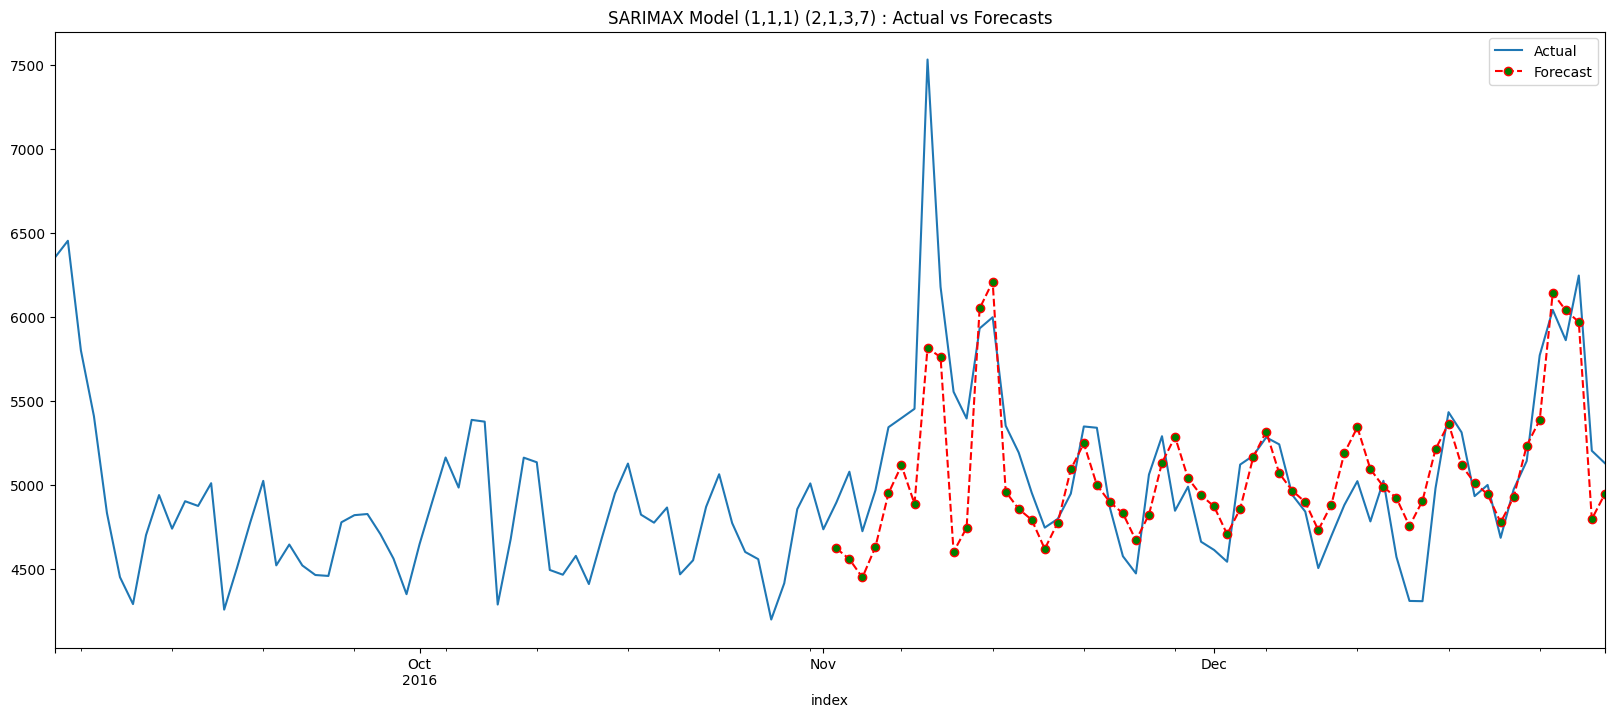

MAE : 269.232
RMSE : 373.568
MAPE: 0.051


(269.232, 373.568, 0.051)

In [48]:
exog = Exog_Campaign_eng['Exog'].to_numpy()
p, d, q = 1, 1, 1
P, D, Q, s = 2, 1, 3, 7
n_forecast = 60

# Fit SARIMAX model
model = SARIMAX(
    TS[:-n_forecast],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    exog=exog[:-n_forecast],
    initialization='approximate_diffuse'
)
model_fit = model.fit()

# Forecast last n_forecast points
model_forecast = model_fit.forecast(
    steps=n_forecast,
    dynamic=True,
    exog=pd.DataFrame(exog[-n_forecast:])
)

# Plot actual vs forecast for last 120 points
plt.figure(figsize=(20, 8))
TS[-120:].plot(label='Actual')
model_forecast.plot(
    label='Forecast',
    color='red',
    linestyle='dashed',
    marker='o',
    markerfacecolor='green'
)
plt.legend(loc="upper right")
plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts')
plt.show()

# Calculate and print performance metrics
performance(TS.values[-n_forecast:], model_forecast.values, print_metrics=True)

Insight

There is good improvement in the SARIMAX model after tuning the parameters

In [49]:
import time

def pipeline_sarimax_grid_search_without_exog(languages, data, n_forecast,
                                           p_list, d_list, q_list,
                                           P_list, D_list, Q_list, s_list):
    """
    Grid search SARIMAX with optional exogenous variables.
    Returns: results_df (all combinations) and best_param_df (best params per language)
    """

    results_df = pd.DataFrame(columns=['language', 'pdq', 'PDQs', 'mape'])
    best_param_df = pd.DataFrame(columns=['language', 'p', 'd', 'q', 'P', 'D', 'Q', 's', 'MAPE'])

    total_combinations = (len(p_list) * len(d_list) * len(q_list) *
                          len(P_list) * len(D_list) * len(Q_list) * len(s_list))

    last_print_time = time.time()

    for lang in languages:
        TS = data[lang]

        best_mape = np.inf
        best_params = None
        counter = 0

        for p in p_list:
            for d in d_list:
                for q in q_list:
                    for P in P_list:
                        for D in D_list:
                            for Q in Q_list:
                                for s in s_list:
                                    try:
                                        # Fit SARIMAX model
                                        model = SARIMAX(
                                            TS[:-n_forecast],
                                            order=(p, d, q),
                                            seasonal_order=(P, D, Q, s),

                                            initialization='approximate_diffuse'
                                        )
                                        model_fit = model.fit(disp=False)

                                        # Forecast
                                        forecast = model_fit.forecast(
                                            steps=n_forecast

                                        )

                                        # Calculate MAPE
                                        actuals = TS.values[-n_forecast:]
                                        errors = actuals - forecast.values
                                        mape = np.mean(np.abs(errors) / np.abs(actuals))

                                        counter += 1
                                        results_df.loc[len(results_df)] = [lang, (p, d, q), (P, D, Q, s), mape]

                                        # Track best parameters
                                        if mape < best_mape:
                                            best_mape = mape
                                            best_params = (p, d, q, P, D, Q, s)

                                        # Print progress every 30 seconds
                                        current_time = time.time()
                                        if current_time - last_print_time >= 30:
                                            percent_done = (counter / total_combinations) * 100
                                            print(f"[{lang}] Progress: {percent_done:.2f}% ({counter}/{total_combinations})")
                                            last_print_time = current_time

                                    except Exception:
                                        continue

        # Save best parameters for this language
        if best_params:
            best_param_df.loc[len(best_param_df)] = [lang, *best_params, best_mape]

        # Final best result for this language
        print(f"\nLanguage: {lang}")
        print(f"Best MAPE: {best_mape}")
        print(f"Best Parameters: {best_params}")
        print("--------------------------------------------------\n")

    return results_df, best_param_df


In [50]:
# List of time series columns
languages = df_agg.columns[:-1]
n_forecast = 60

# SARIMAX grid search parameters
p_list = [0, 1]
d_list = [1]
q_list = [0, 1]

P_list = [2, 3]
D_list = [1]
Q_list = [2, 3]
s_list = [7]

# External regressor (exogenous variable)
exog = Exog_Campaign_eng['Exog'].to_numpy()

# Run SARIMAX grid search with exogenous variable
results_df, best_param_df = pipeline_sarimax_grid_search_without_exog(
    languages, df_agg, n_forecast,
    p_list, d_list, q_list,
    P_list, D_list, Q_list, s_list
)

[Chinese] Progress: 43.75% (7/16)
[Chinese] Progress: 81.25% (13/16)

Language: Chinese
Best MAPE: 0.05093633872969188
Best Parameters: (0, 1, 1, 3, 1, 2, 7)
--------------------------------------------------

[English] Progress: 12.50% (2/16)
[English] Progress: 50.00% (8/16)
[English] Progress: 87.50% (14/16)

Language: English
Best MAPE: 0.07887191927788541
Best Parameters: (1, 1, 1, 2, 1, 3, 7)
--------------------------------------------------

[French] Progress: 25.00% (4/16)
[French] Progress: 68.75% (11/16)
[French] Progress: 100.00% (16/16)

Language: French
Best MAPE: 0.06394818305730827
Best Parameters: (1, 1, 0, 2, 1, 3, 7)
--------------------------------------------------

[German] Progress: 50.00% (8/16)
[German] Progress: 93.75% (15/16)

Language: German
Best MAPE: 0.06481826462997445
Best Parameters: (1, 1, 1, 2, 1, 2, 7)
--------------------------------------------------

[Japanese] Progress: 31.25% (5/16)
[Japanese] Progress: 75.00% (12/16)

Language: Japanese
Best M

In [51]:
# Sort results by MAPE then RMSE
sorted_perf_df = results_df.sort_values(['mape']).reset_index(drop=True)

# Display outputs
print(sorted_perf_df.head())  # All combinations sorted by MAPE
print("----"*20)
print(best_param_df)          # Best parameters per series

  language        pdq          PDQs      mape
0  Chinese  (0, 1, 1)  (3, 1, 2, 7)  0.050936
1  Chinese  (0, 1, 1)  (3, 1, 3, 7)  0.050952
2  Chinese  (0, 1, 1)  (2, 1, 2, 7)  0.053133
3  Chinese  (1, 1, 1)  (2, 1, 3, 7)  0.054241
4  Chinese  (1, 1, 1)  (3, 1, 2, 7)  0.054397
--------------------------------------------------------------------------------
   language  p  d  q  P  D  Q  s      MAPE
0   Chinese  0  1  1  3  1  2  7  0.050936
1   English  1  1  1  2  1  3  7  0.078872
2    French  1  1  0  2  1  3  7  0.063948
3    German  1  1  1  2  1  2  7  0.064818
4  Japanese  1  1  1  2  1  2  7  0.057882
5   Russian  0  1  0  3  1  3  7  0.070290
6   Spanish  1  1  1  3  1  2  7  0.125562


In [52]:
def plot_best_SARIMAX_model(languages, data, n, best_param_df):
    for lang in languages:
        # Fetching respective best parameters for that language
        p = best_param_df.loc[best_param_df['language'] == lang, 'p'].values[0]
        d = best_param_df.loc[best_param_df['language'] == lang, 'd'].values[0]
        q = best_param_df.loc[best_param_df['language'] == lang, 'q'].values[0]
        P = best_param_df.loc[best_param_df['language'] == lang, 'P'].values[0]
        D = best_param_df.loc[best_param_df['language'] == lang, 'D'].values[0]
        Q = best_param_df.loc[best_param_df['language'] == lang, 'Q'].values[0]
        s = best_param_df.loc[best_param_df['language'] == lang, 's'].values[0]

        # Creating language time series
        time_series = data[lang]

        # Creating SARIMAX Model
        model = SARIMAX(
            time_series[:-n],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            initialization='approximate_diffuse'
        )
        model_fit = model.fit(disp=False)

        # Forecast for last n values
        model_forecast = model_fit.forecast(n, dynamic=True)

        # Calculate MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = actuals - model_forecast.values
        mape = np.mean(np.abs(errors) / np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))

        # Print model metrics
        print("\n--------------------------------------------------")
        print(f"SARIMAX model for {lang} Time Series")
        print(f"Parameters of Model : ({p},{d},{q})  ({P},{D},{Q},{s})")
        print(f"MAPE of Model       : {np.round(mape, 5)}")
        print(f"RMSE of Model       : {np.round(rmse, 3)}")
        print("--------------------------------------------------\n")

        # Plot Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize=(20, 8))
        time_series[-60:].plot(label='Actual')
        model_forecast[-60:].plot(label='Forecast', color='red',
                                  linestyle='dashed', marker='o', markerfacecolor='green')
        plt.legend()
        plt.title(f"SARIMAX Forecast for {lang}")
        plt.show()



--------------------------------------------------
SARIMAX model for Chinese Time Series
Parameters of Model : (0,1,1)  (3,1,2,7)
MAPE of Model       : 0.0339
RMSE of Model       : 15.603
--------------------------------------------------



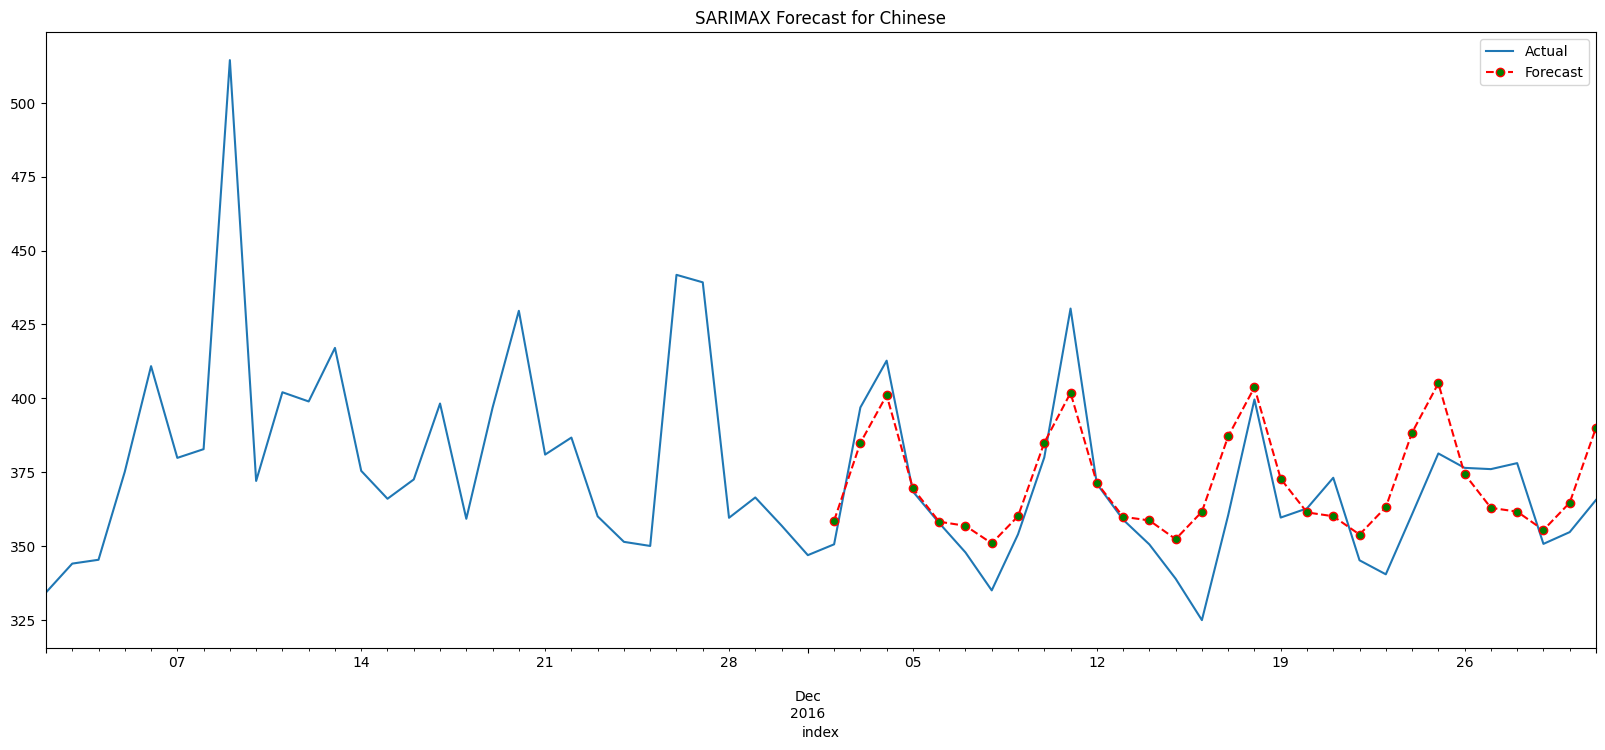


--------------------------------------------------
SARIMAX model for English Time Series
Parameters of Model : (1,1,1)  (2,1,3,7)
MAPE of Model       : 0.08742
RMSE of Model       : 608.108
--------------------------------------------------



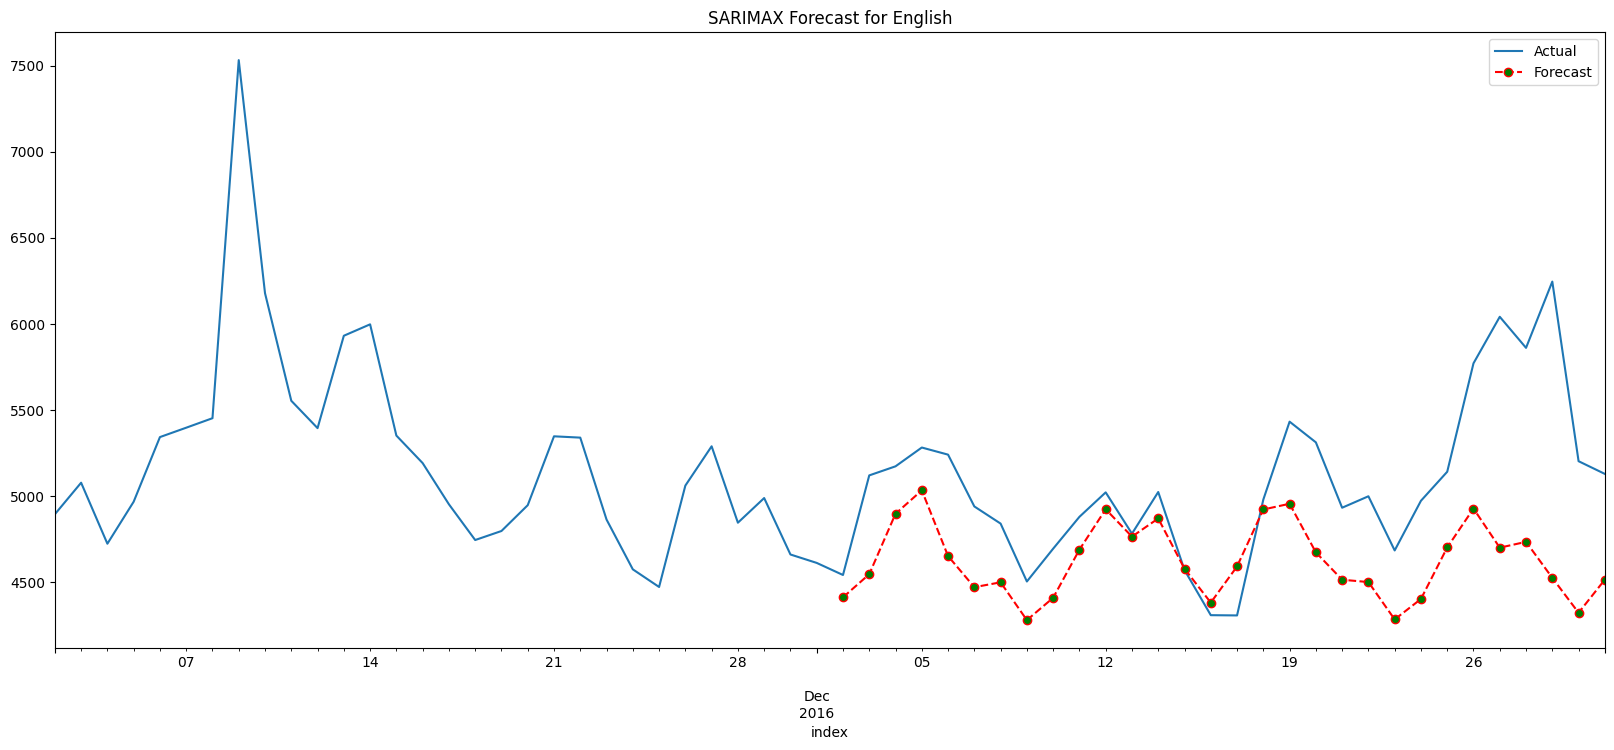


--------------------------------------------------
SARIMAX model for French Time Series
Parameters of Model : (1,1,0)  (2,1,3,7)
MAPE of Model       : 0.10681
RMSE of Model       : 103.769
--------------------------------------------------



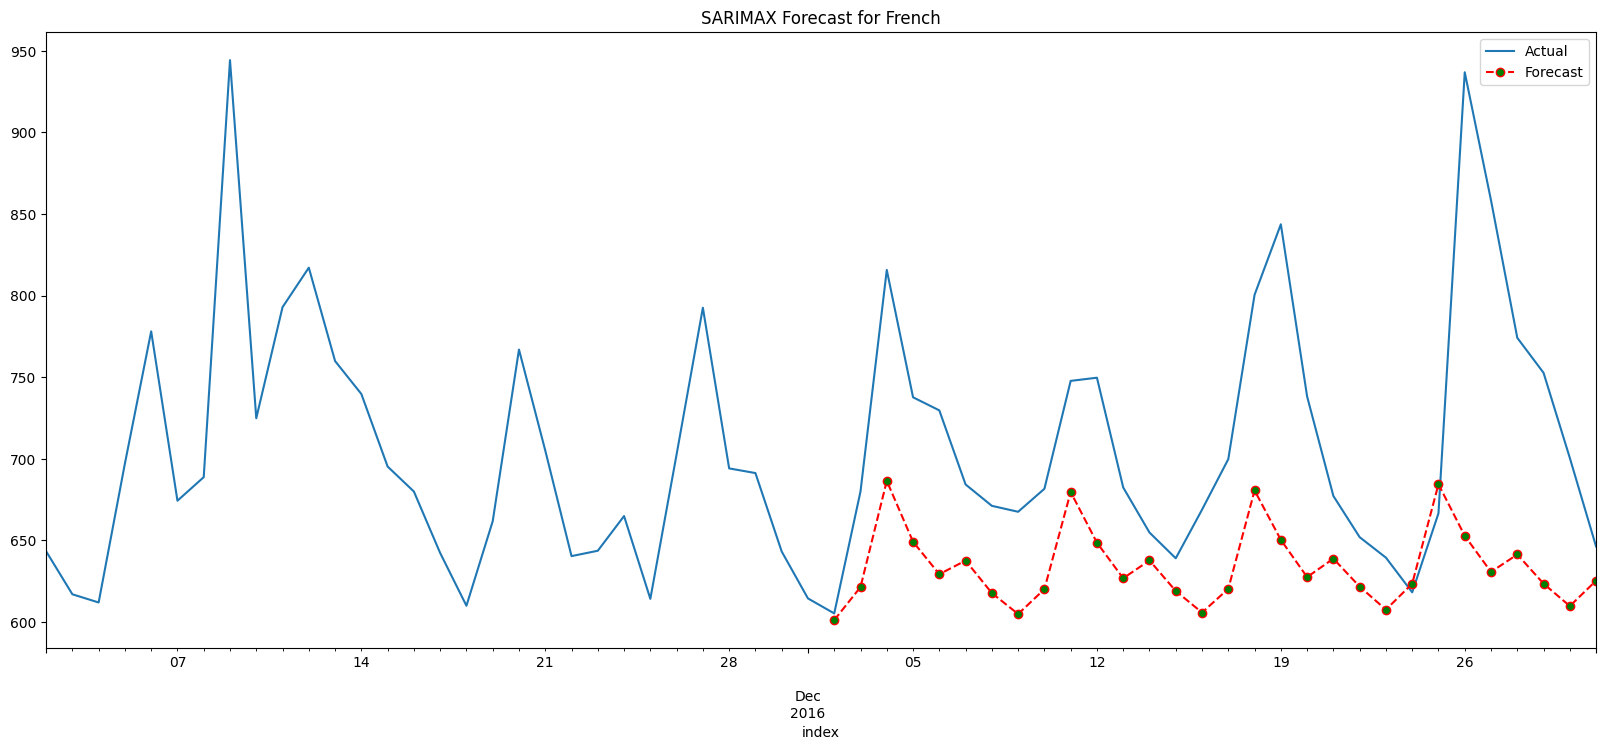


--------------------------------------------------
SARIMAX model for German Time Series
Parameters of Model : (1,1,1)  (2,1,2,7)
MAPE of Model       : 0.07434
RMSE of Model       : 100.974
--------------------------------------------------



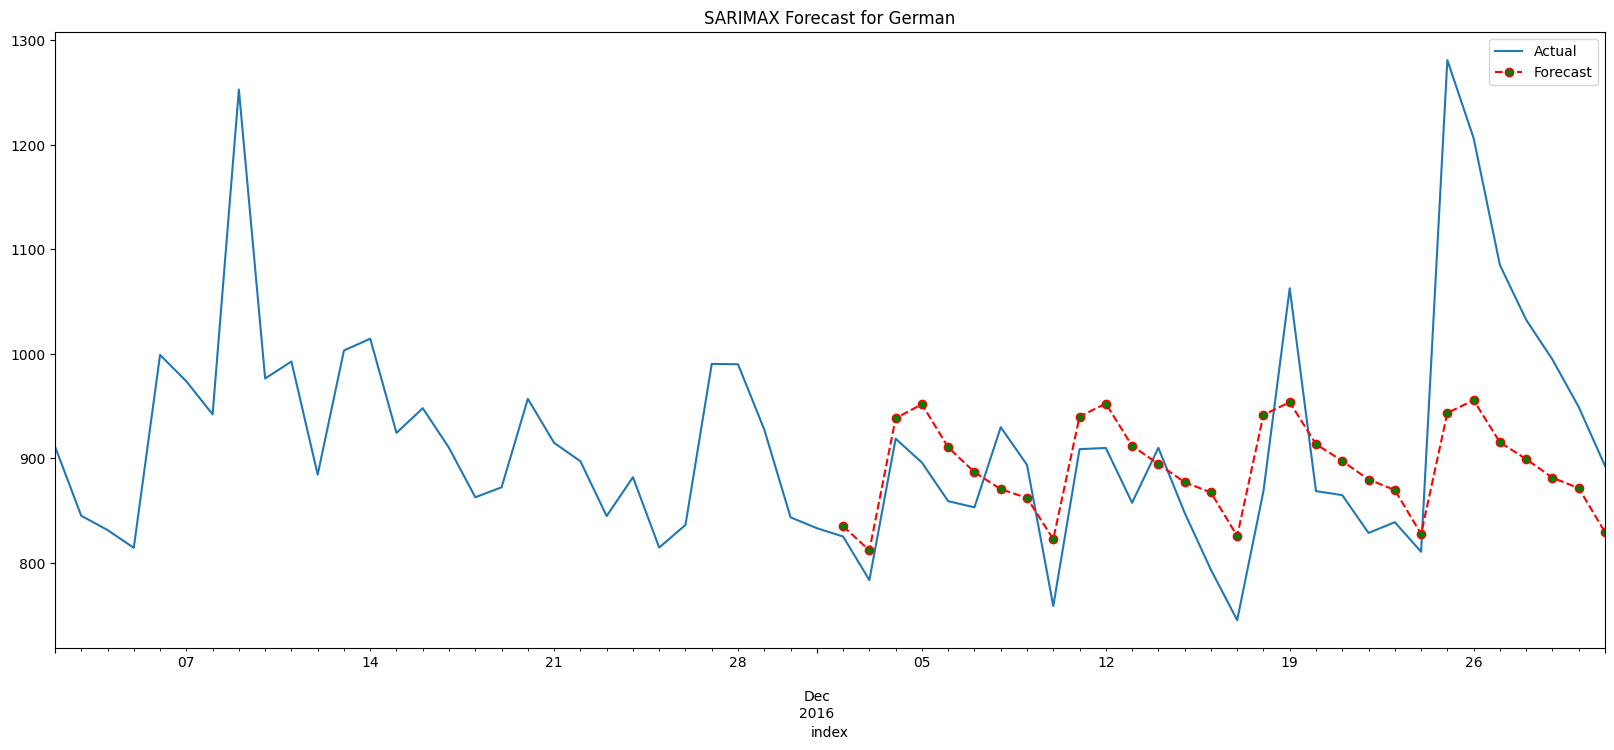


--------------------------------------------------
SARIMAX model for Japanese Time Series
Parameters of Model : (1,1,1)  (2,1,2,7)
MAPE of Model       : 0.07249
RMSE of Model       : 101.399
--------------------------------------------------



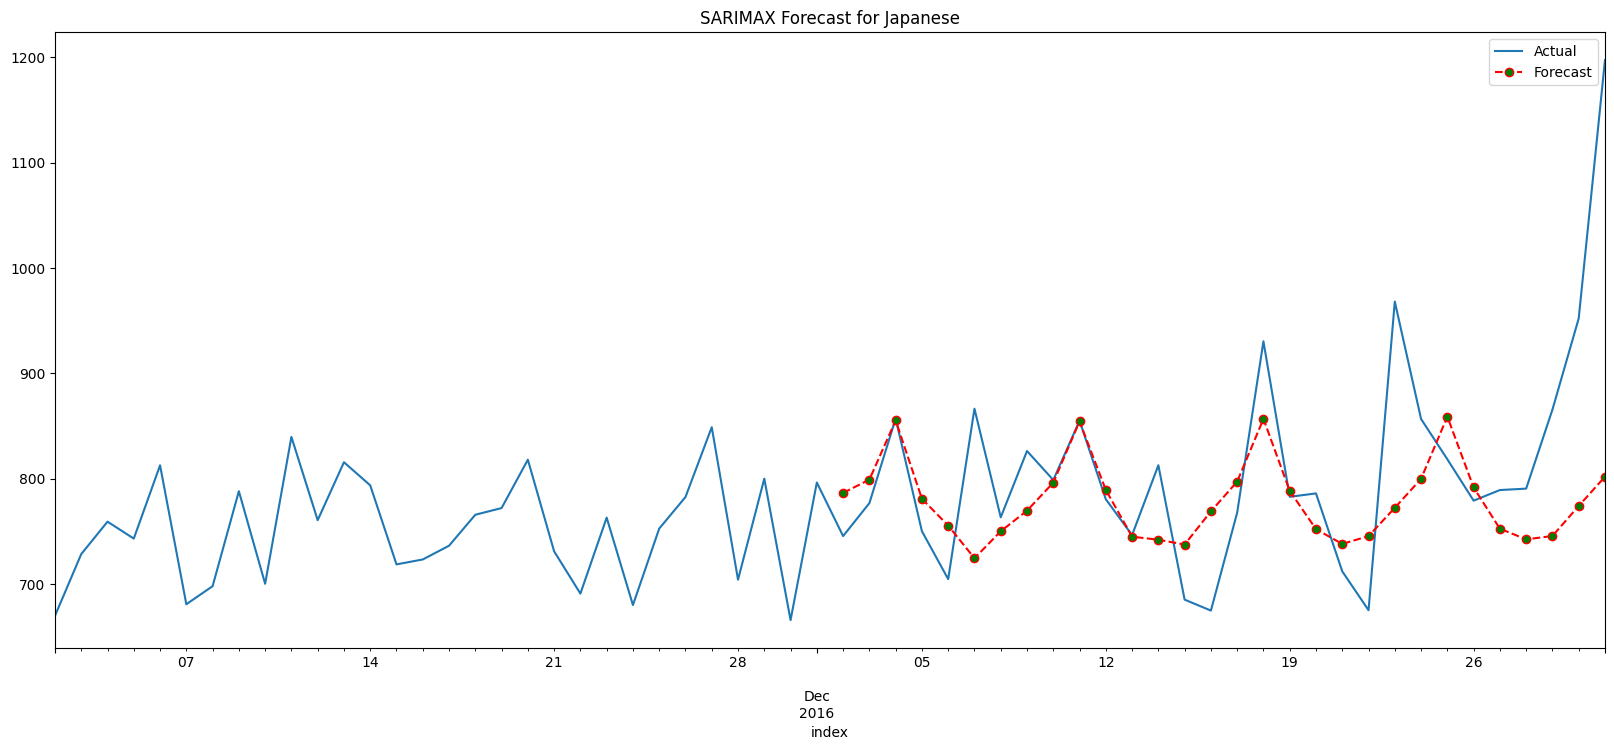


--------------------------------------------------
SARIMAX model for Russian Time Series
Parameters of Model : (0,1,0)  (3,1,3,7)
MAPE of Model       : 0.13227
RMSE of Model       : 135.636
--------------------------------------------------



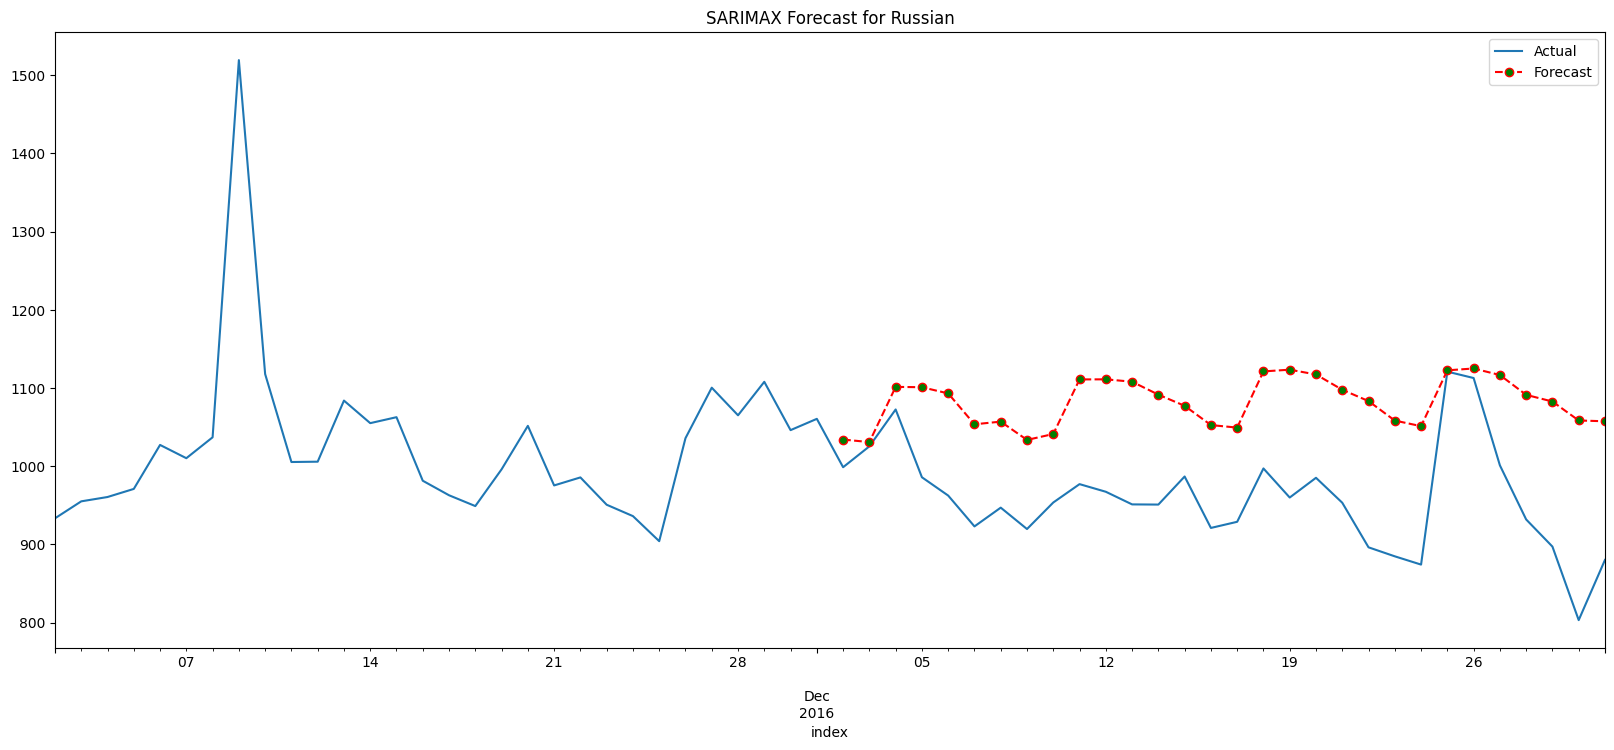


--------------------------------------------------
SARIMAX model for Spanish Time Series
Parameters of Model : (1,1,1)  (3,1,2,7)
MAPE of Model       : 0.23868
RMSE of Model       : 257.668
--------------------------------------------------



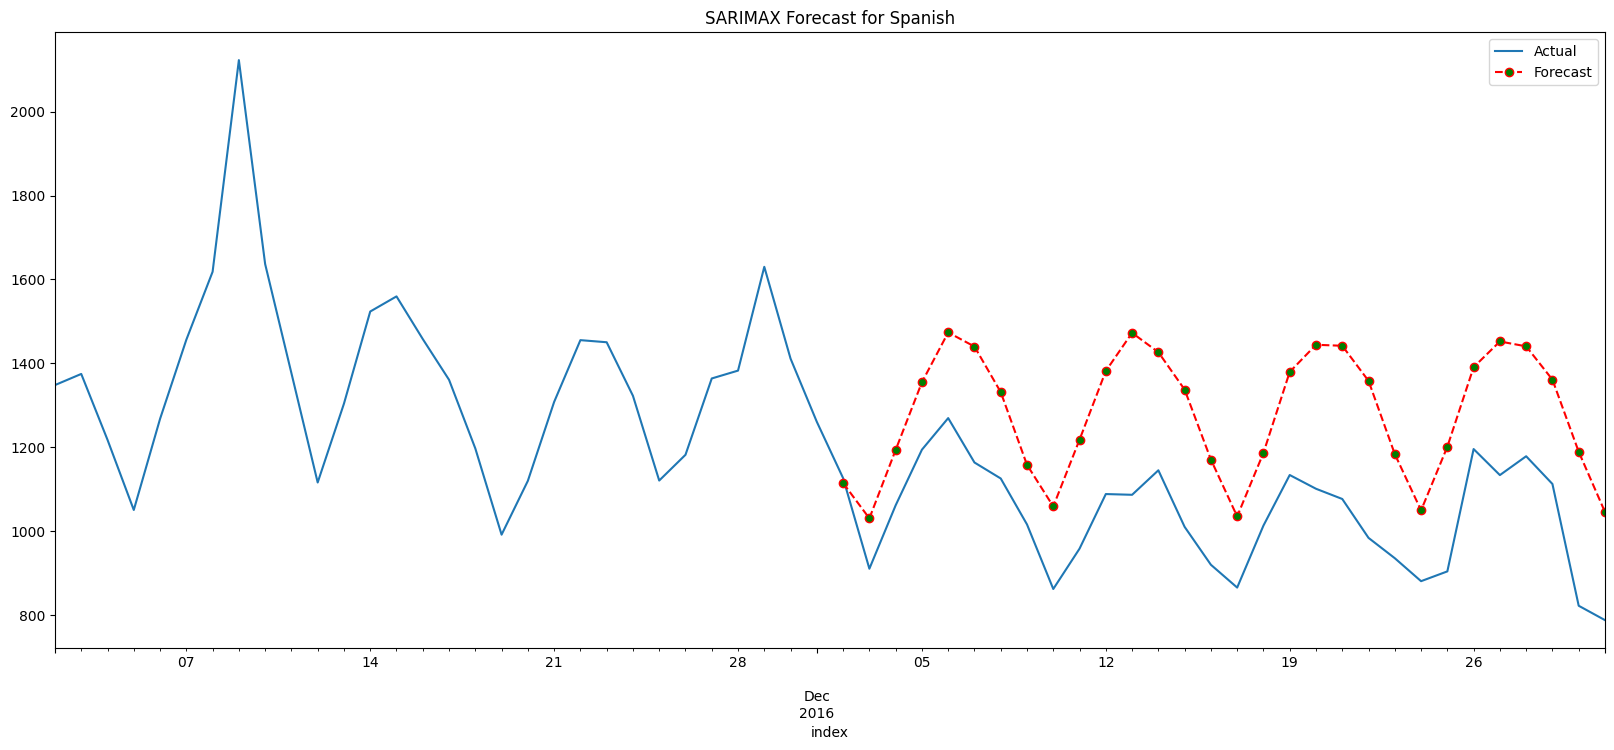

In [53]:
languages = df_agg.columns[:-1]
n=30
plot_best_SARIMAX_model(languages, df_agg, n, best_param_df)



> **Forecasting using Facebook Prophet**



In [54]:
#!pip install numpy==1.22.4

In [55]:
!pip install prophet

In [56]:
TS = ts_english.copy(deep=True).reset_index()
TS = TS[['index', 'English']]
TS.columns = ['ds', 'y']
TS['ds'] = pd.to_datetime(TS['ds'])

exog = Exog_Campaign_eng['Exog']
TS['exog'] = exog.values

TS.tail()


ds            y  exog
545 2016-12-27  6040.680728     1
546 2016-12-28  5860.227559     1
547 2016-12-29  6245.127510     1
548 2016-12-30  5201.783018     0
549 2016-12-31  5127.916418     0

In [57]:
from prophet import Prophet

# Initialize Prophet model with specified parameters
prophet_model = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False
)

# Add external regressor column 'exog'
prophet_model.add_regressor('exog')

# Number of days to forecast (currently zero extension)
forecast_horizon = 0

# Fit the model on the time series data
prophet_model.fit(TS)

# Create a dataframe with future dates for prediction (here, no extension)
future_df = prophet_model.make_future_dataframe(periods=forecast_horizon)

# Add the external regressor values for these dates
future_df['exog'] = TS['exog']

# Predict future values using the model
forecast_df = prophet_model.predict(future_df)

# Merge predictions with original dataset
TS['predicted_visits'] = forecast_df['yhat']
TS['predicted_upper'] = forecast_df['yhat_upper']
TS['predicted_lower'] = forecast_df['yhat_lower']

# Evaluate performance (assuming performance() is defined elsewhere)
(_, _, _) = performance(TS['y'], TS['predicted_visits'], print_metrics=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/eb0b0fjl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/9why0zcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81358', 'data', 'file=/tmp/tmpgd7uit3m/eb0b0fjl.json', 'init=/tmp/tmpgd7uit3m/9why0zcf.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_modelkinv7i98/prophet_model-20250809160551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 287.417
RMSE : 441.959
MAPE: 0.06


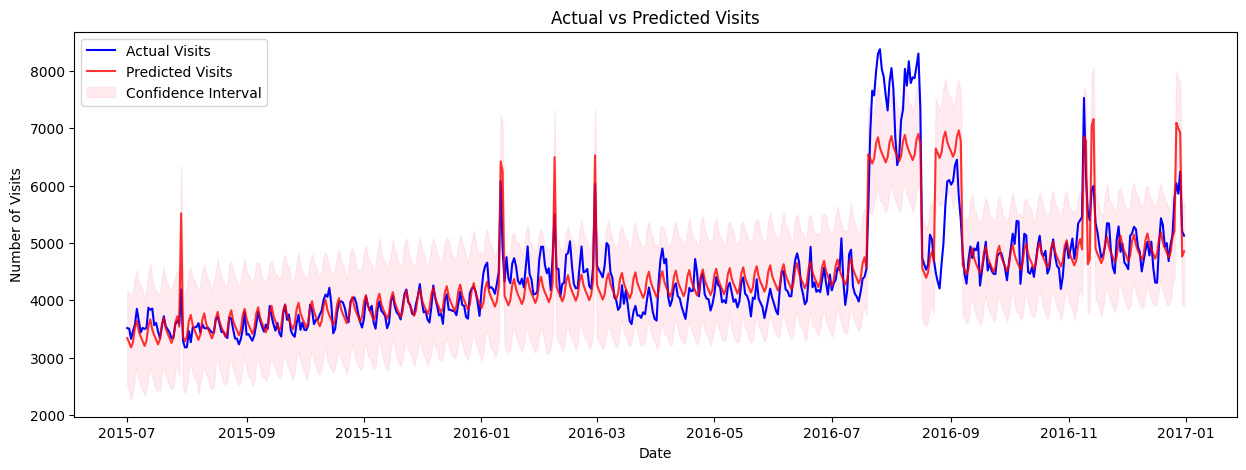

In [58]:
# Plot actual vs predicted visits with confidence intervals
plt.figure(figsize=(15, 5))
plt.plot(TS['ds'], TS['y'], label='Actual Visits', color='blue')
plt.plot(TS['ds'], TS['predicted_visits'], label='Predicted Visits', color='red', alpha=0.8)
plt.fill_between(
    TS['ds'],
    TS['predicted_lower'],
    TS['predicted_upper'],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Actual vs Predicted Visits')
plt.legend()
plt.show()

Insight

Prophet is doing an incredible job capturing the trend and unusual peaks. It is also capturing the seasonality very well

Comparison


Processing language: Chinese


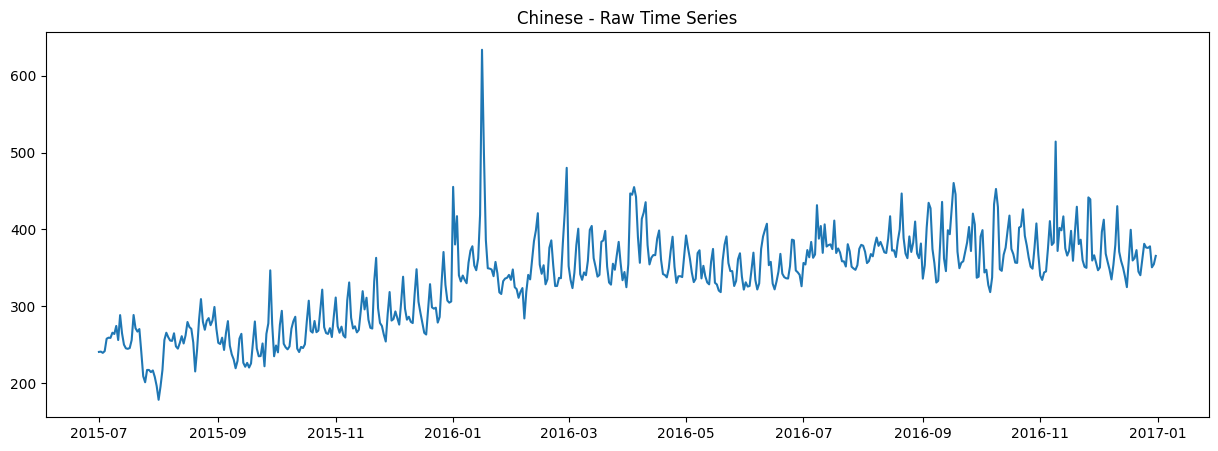

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/vg4s0c2h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/mpjq05uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29081', 'data', 'file=/tmp/tmpgd7uit3m/vg4s0c2h.json', 'init=/tmp/tmpgd7uit3m/mpjq05uv.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_modeldwo4v4pt/prophet_model-20250809160552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 19.21
RMSE : 28.605
MAPE: 0.058


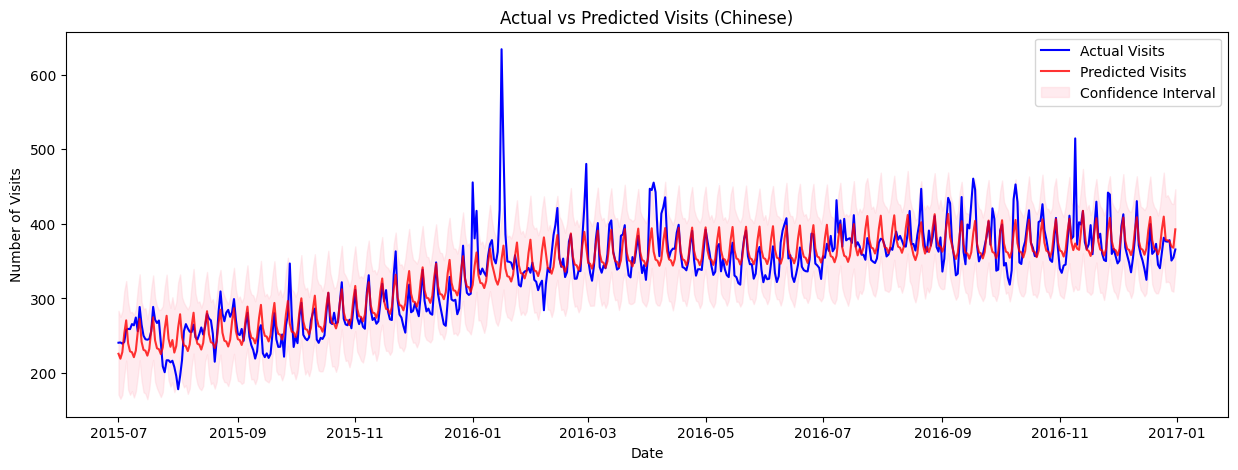


Processing language: English


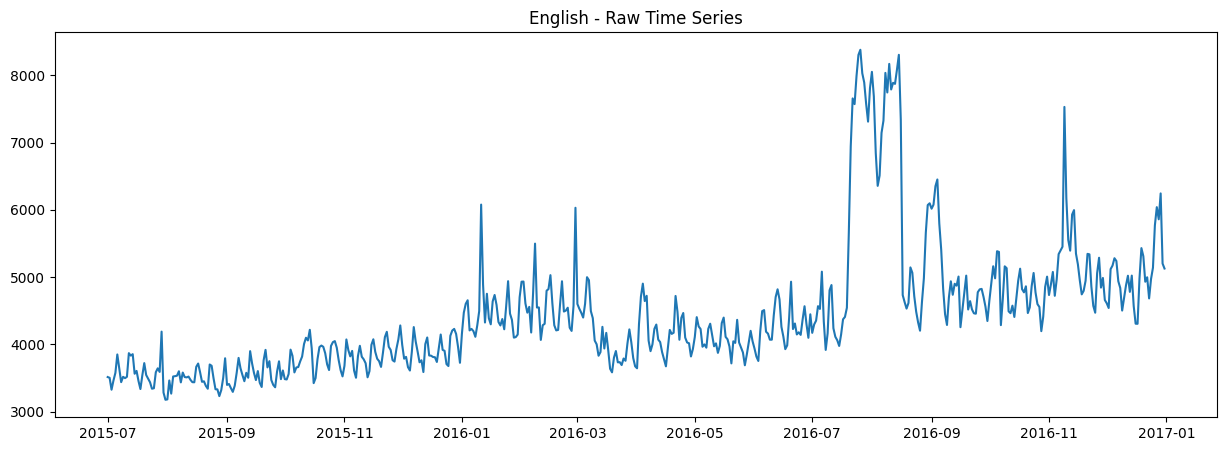

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/_2e2eips.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/s5fasmed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39826', 'data', 'file=/tmp/tmpgd7uit3m/_2e2eips.json', 'init=/tmp/tmpgd7uit3m/s5fasmed.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_model1br30mu9/prophet_model-20250809160553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 287.417
RMSE : 441.959
MAPE: 0.06


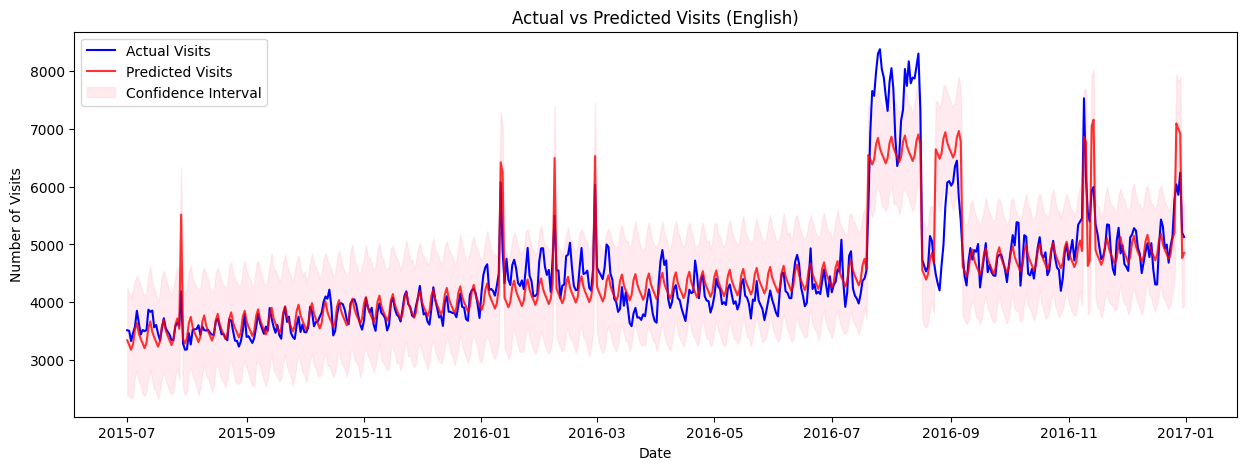


Processing language: French


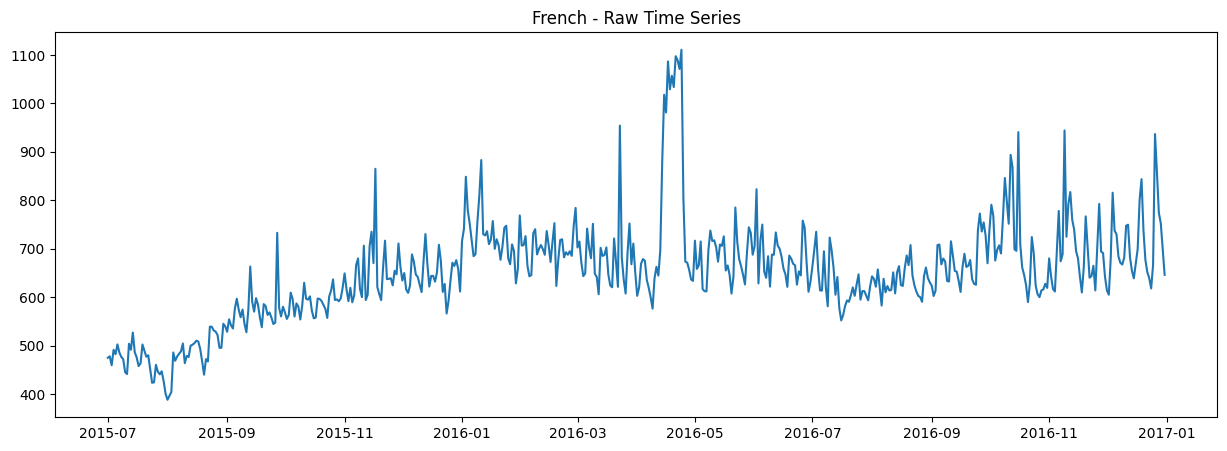

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/b03tn29m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/0y2xqzeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86439', 'data', 'file=/tmp/tmpgd7uit3m/b03tn29m.json', 'init=/tmp/tmpgd7uit3m/0y2xqzeg.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_model9vfqjsp1/prophet_model-20250809160555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 41.967
RMSE : 69.101
MAPE: 0.061


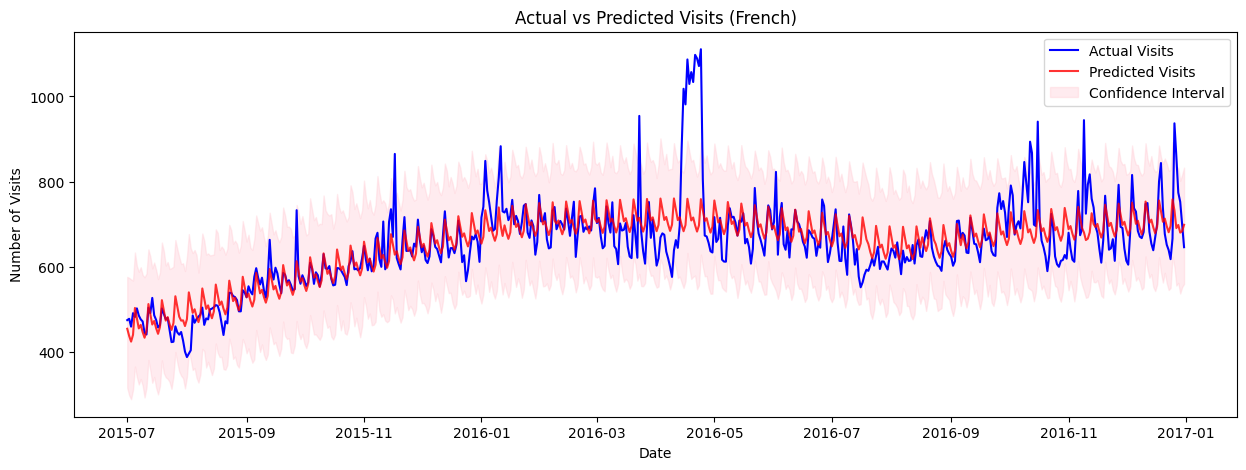


Processing language: German


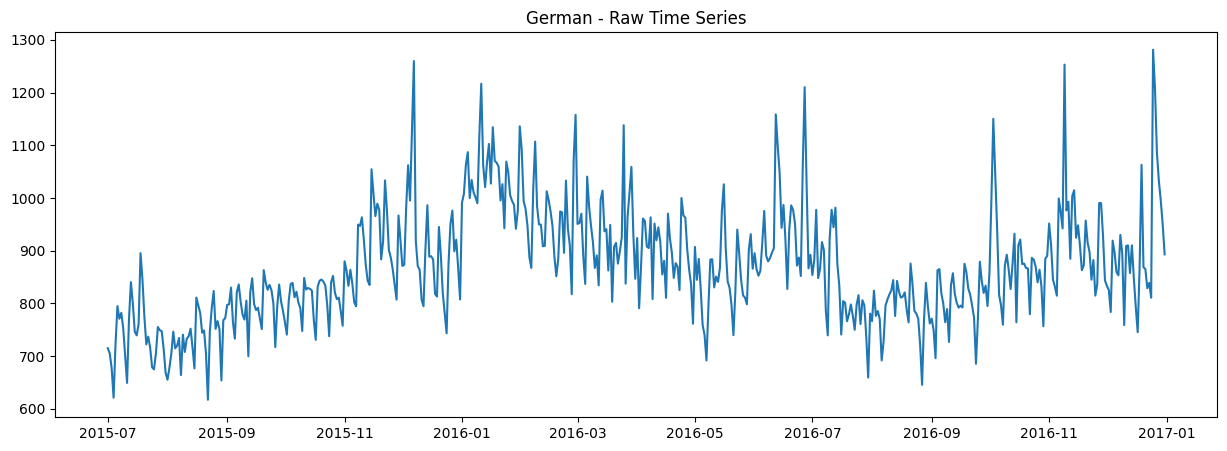

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/qobiztqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/44gwviwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84452', 'data', 'file=/tmp/tmpgd7uit3m/qobiztqy.json', 'init=/tmp/tmpgd7uit3m/44gwviwv.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_model95_ahrr_/prophet_model-20250809160556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 49.19
RMSE : 68.281
MAPE: 0.055


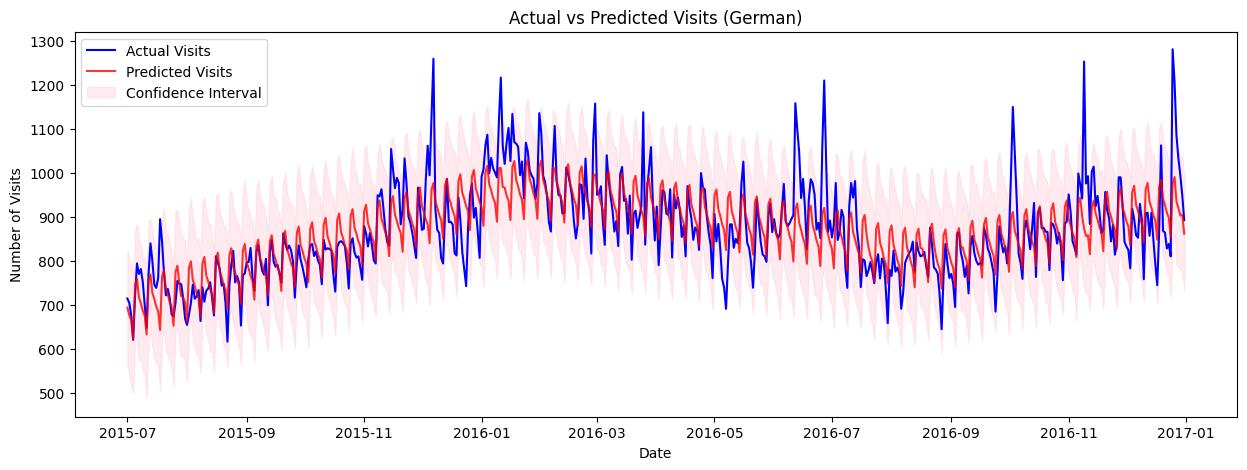


Processing language: Japanese


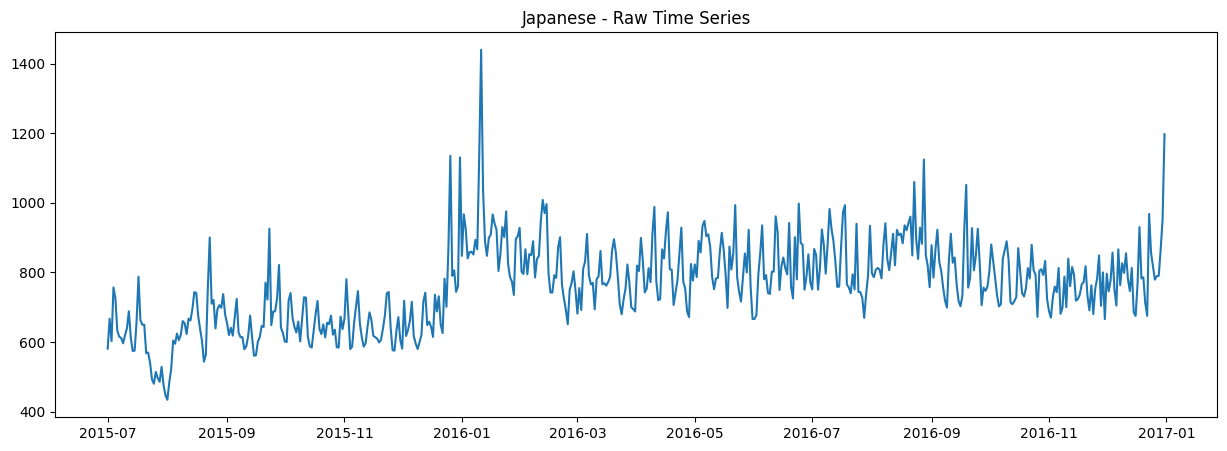

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/pg_997gq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/yp_0ywzg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57463', 'data', 'file=/tmp/tmpgd7uit3m/pg_997gq.json', 'init=/tmp/tmpgd7uit3m/yp_0ywzg.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_model42s1ruyc/prophet_model-20250809160558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 60.863
RMSE : 83.525
MAPE: 0.08


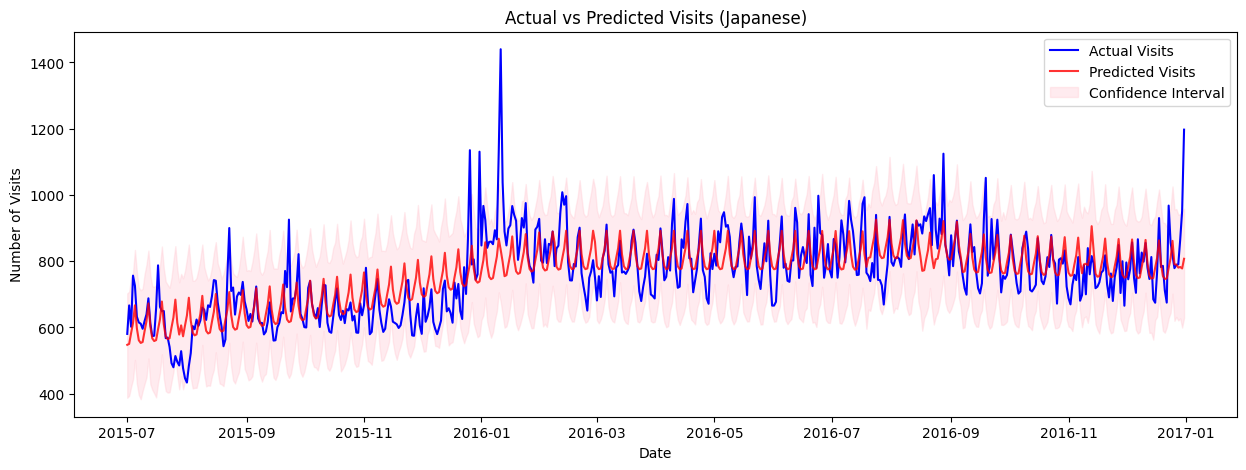


Processing language: Russian


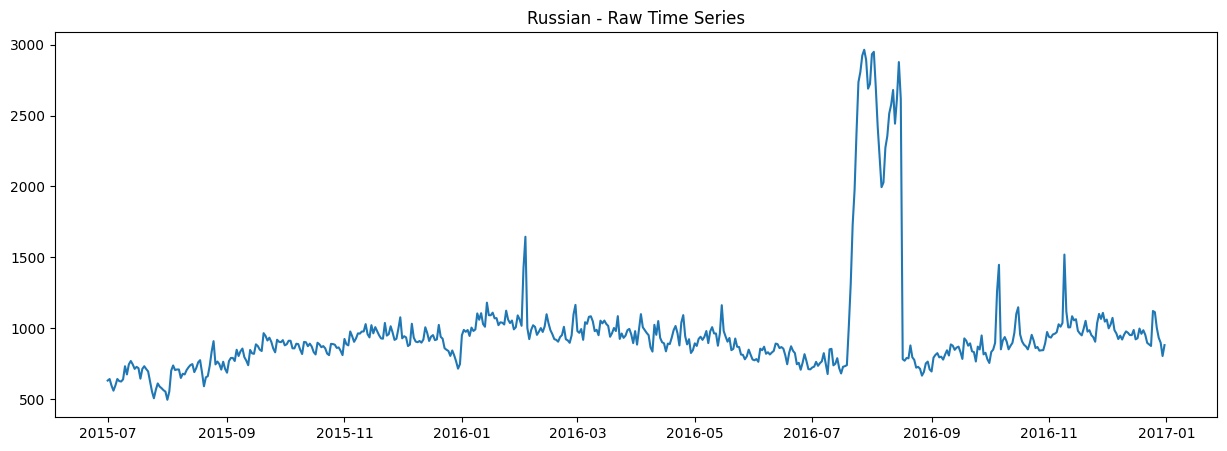

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/w1cvnxcf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/h5z29cf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24575', 'data', 'file=/tmp/tmpgd7uit3m/w1cvnxcf.json', 'init=/tmp/tmpgd7uit3m/h5z29cf2.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_model4suicfgb/prophet_model-20250809160600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 148.58
RMSE : 285.614
MAPE: 0.143


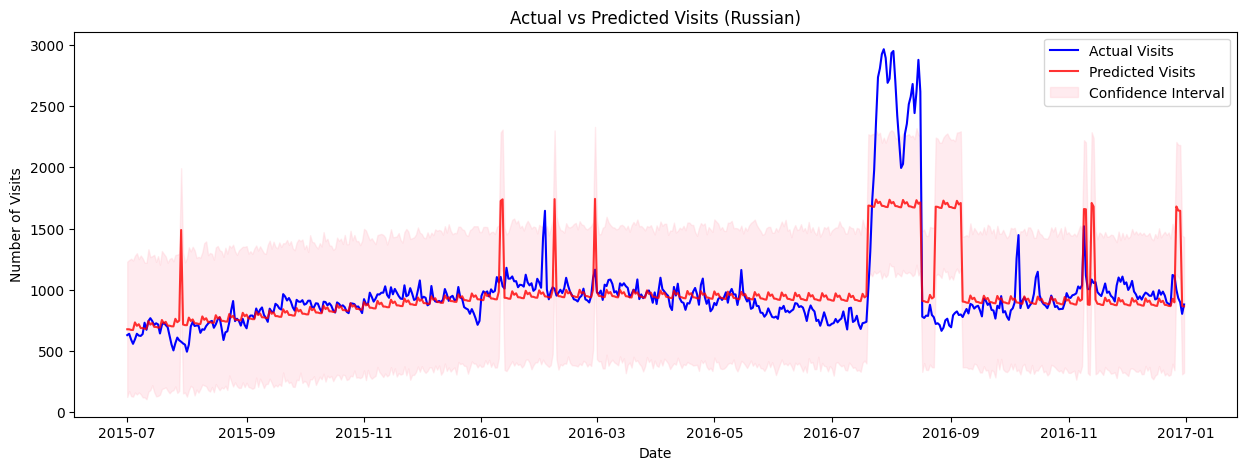


Processing language: Spanish


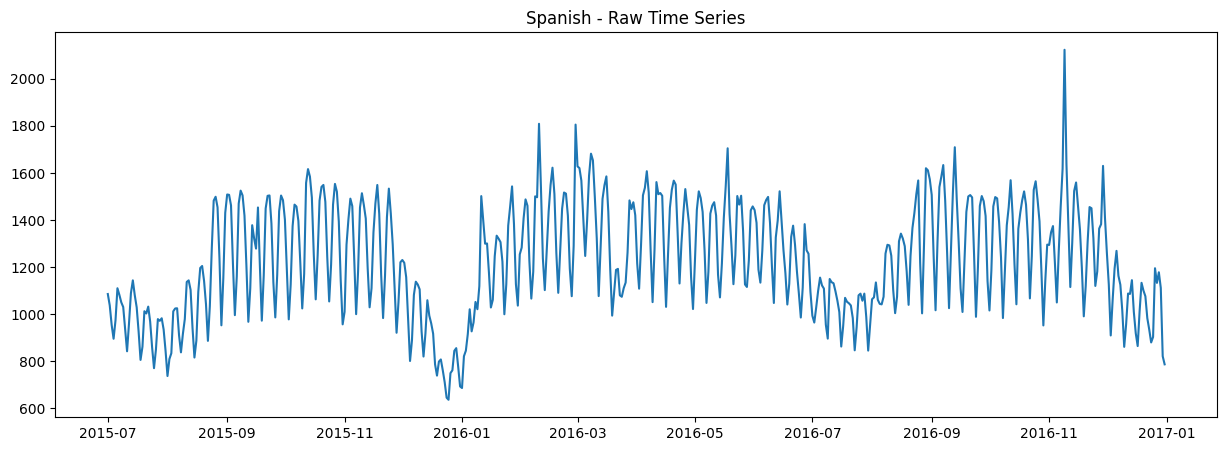

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/wpnn6sur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgd7uit3m/_yl6h14g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77789', 'data', 'file=/tmp/tmpgd7uit3m/wpnn6sur.json', 'init=/tmp/tmpgd7uit3m/_yl6h14g.json', 'output', 'file=/tmp/tmpgd7uit3m/prophet_modelheqdzn8q/prophet_model-20250809160604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:06:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE : 133.412
RMSE : 173.281
MAPE: 0.117


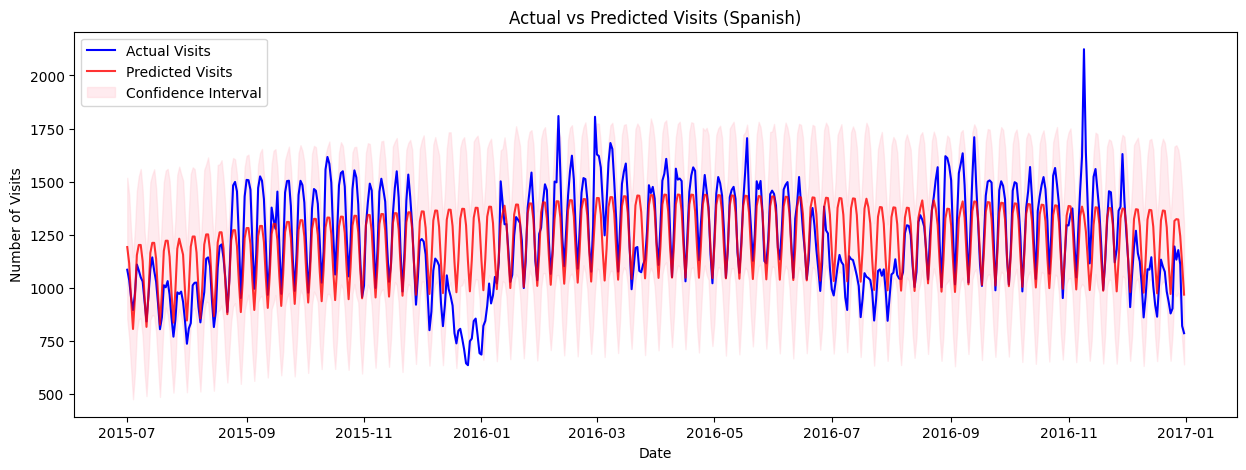

In [59]:
from prophet import Prophet

# Prepare exogenous variable as numpy array
exog = Exog_Campaign_eng['Exog'].to_numpy()

# Loop through all language columns (excluding index/date columns)
for lang in df_agg.columns[:-1]:
    print(f"\nProcessing language: {lang}")

    # Step 1: Prepare time series
    TS = df_agg[lang].copy(deep=True)
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(TS.index, TS)
    ax.set_title(f"{lang} - Raw Time Series")
    plt.show()

    # Step 2: Prepare DataFrame for Prophet
    TS = TS.reset_index()
    TS = TS.rename(columns={"index": "ds", lang: "y"})
    TS["ds"] = pd.to_datetime(TS["ds"])

    # Add exogenous variable
    TS["exog"] = exog  # Aligns row-wise with TS

    # Step 3: Fit Prophet model with regressor
    my_model = Prophet(
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False
    )
    my_model.add_regressor("exog")

    my_model.fit(TS)

    # Step 4: Create future dataframe (no extra periods here)
    future_dates = my_model.make_future_dataframe(periods=0)
    future_dates["exog"] = exog  # Must be provided for all prediction points

    forecast = my_model.predict(future_dates)

    # Step 5: Merge predictions
    TS["yhat"] = forecast["yhat"]
    TS["yhat_upper"] = forecast["yhat_upper"]
    TS["yhat_lower"] = forecast["yhat_lower"]

    # Step 6: Evaluate model
    (_, _, _) = performance(TS["y"], TS["yhat"], print_metrics=True)

    # Step 7: Plot actual vs predicted visits
    plt.figure(figsize=(15, 5))
    plt.plot(TS["ds"], TS["y"], label="Actual Visits", color="blue")
    plt.plot(TS["ds"], TS["yhat"], label="Predicted Visits", color="red", alpha=0.8)
    plt.fill_between(
        TS["ds"], TS["yhat_lower"], TS["yhat_upper"],
        color="pink", alpha=0.3, label="Confidence Interval"
    )

    plt.xlabel("Date")
    plt.ylabel("Number of Visits")
    plt.title(f"Actual vs Predicted Visits ({lang})")
    plt.legend()
    plt.show()



> **Insights**





*   There are 7 known language pages in the dataset - English, Japanese, German,French, Chinese, Russian and Spanish
*   English has the maximum number of pages, 16.62%. This is excpected as the maximum people speak English
*   Decomposition helps in understanding the underlying trend, seasonality and error(residual) in the time series data.
*  As per the analysis done on English language time series data, a differencing of 1 gives a stationary series. This is also tested using Augmented Dickey-Fuller test
*   As per the exogenous variable given, the visits to the English page has an unusual peak whenever the exogenous variable is 1
*   The performance of AdEase will be effected by events or campaings. AdEase can use the Prophet model along with exogenous variable to improve their predictions
Without the exogenous variable, it becomes impossible to make accurate predictions. This is demonstarted by the plots of other languages which do not have exogneous variable













What level of differencing gave you a stationary series?

 - Typically, a first-order differencing (d=1) is applied to remove trends and achieve stationarity in many time series. If seasonality is present, seasonal differencing (e.g., differencing at lag 12 for monthly data) may also be required. The exact differencing level depends on tests like the Augmented Dickey-Fuller (ADF) test, but often:

 - Non-seasonal differencing (d=1) is enough for most series,

 - Seasonal differencing (D=1) at seasonal lag is used for seasonal patterns.

What other methods other than grid search would be suitable to get the model for all languages?

 - Random Search: Samples parameter combinations randomly, often more efficient than grid search when the parameter space is large.

 - Bayesian Optimization: Uses probabilistic models to select promising hyperparameters intelligently, speeding up convergence to the best model.

What does the decomposition of series do?

Decomposition splits a time series into:  
- **Trend:** Long-term progression  
- **Seasonality:** Repeating patterns at fixed intervals  
- **Residual (Noise):** Random fluctuations after removing trend and seasonality  

This clarifies underlying patterns and aids modeling.



> **ARIMA**

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting model that handles time series data with trends but without strong seasonality. It is composed of three parts: AR (AutoRegression), which uses past values (lags) of the series to predict the current value; I (Integrated), which differences the series to remove trends and make it stationary; and MA (Moving Average), which uses past forecast errors to improve predictions. Its parameters are p (autoregressive order), d (degree of differencing), and q (moving average order). ARIMA is best used when the data shows a trend but no seasonal cycles, making it a simple and reliable baseline for forecasting—for example, predicting stock prices where seasonal effects are minimal.

> **SARIMA**

SARIMA (Seasonal ARIMA) extends ARIMA by directly modeling seasonality in addition to trends. It retains the non-seasonal terms (p, d, q) from ARIMA and adds seasonal terms (P, D, Q, s), where P is the seasonal autoregressive order, D is the seasonal differencing order, Q is the seasonal moving average order, and s is the number of periods per season (e.g., s=12 for monthly data with yearly seasonality). SARIMA is ideal when data has both trend and strong, repeating seasonal patterns, which ARIMA alone cannot capture. A common use case would be forecasting monthly electricity demand, where usage peaks occur in predictable cycles such as summer and winter.

> **SARIMAX**

SARIMAX (Seasonal ARIMA with eXogenous variables) builds on SARIMA by allowing the inclusion of one or more external variables (exogenous inputs) alongside seasonal modeling. It uses the same seasonal and non-seasonal parameters but adds the “exog” term for extra predictors that can be either continuous or categorical. This is useful when the time series is influenced not only by its own history and seasonality but also by outside factors such as holidays, marketing campaigns, or weather. SARIMAX is best suited for seasonal data where known external variables can improve accuracy, such as forecasting retail sales while accounting for marketing spend, promotional events, or temperature variations.

